In [1]:
import copy
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from Bio import Align

from dataset import *
from utils import *
from models import *

# 1. cov-abdab

## 1.1 EDA

In [2]:
# data = pickle.load(open("../../MSAI_Project/codes/data_files/data.json", "rb"))
# data = pickle.load(open("../../MSAI_Project/codes/data_files/data_list.pkl", "rb"))
data = pickle.load(open("./data/data_list.pkl", "rb"))
type(data), len(data)

(list, 5386)

In [3]:
# must: delete samples with CDR containing "..."
data1 = []
for i in range(len(data)):
    if ("." in data[i]["H1"]) or ("." in data[i]["H2"]) or ("." in data[i]["H3"]) or ("." in data[i]["L1"]) or ("." in data[i]["L2"]) or ("." in data[i]["L3"]):
        pass
    else:
        data1.append(data[i])
        
del data
data = data1
del data1
type(data), len(data)

(list, 5380)

In [4]:
# check . existence
for i in range(len(data)):
    if ("." in data[i]["H1"]) or ("." in data[i]["H2"]) or ("." in data[i]["H3"]) or ("." in data[i]["L1"]) or ("." in data[i]["L2"]) or ("." in data[i]["L3"]):
        print("/".join([data[i]["H1"], data[i]["H2"], data[i]["H3"], data[i]["L1"], data[i]["L2"], data[i]["L3"]]))
        print(i)

# paratope max len
maxlen = 0
for i in range(len(data)):
    cur = len(data[i]["H1"]+data[i]["H2"]+data[i]["H3"]+data[i]["L1"]+data[i]["L2"]+data[i]["L3"])
    maxlen = cur if cur > maxlen else maxlen
print("max len of paratope:", maxlen)


# check integrity of six CDRs
for i in range(len(data)):
    s = "/".join([data[i]["H1"], data[i]["H2"], data[i]["H3"], data[i]["L1"], data[i]["L2"], data[i]["L3"]])
    if len(s.split("/"))!=6:
        print(s)

max len of paratope: 69


In [5]:
data[0].keys()

dict_keys(['pdb', 'Hchain', 'Lchain', 'Achain', 'Hseq', 'Lseq', 'Aseq', 'L1', 'L2', 'L3', 'H1', 'H2', 'H3'])

In [6]:
len(data[0]["Hseq"]["J"])

123

In [7]:
data[0]

{'pdb': '7t17',
 'Hchain': 'J',
 'Lchain': 'K',
 'Achain': ['C'],
 'Hseq': {'J': [{'name': 'GLN',
    'abbr': 'Q',
    'pos': array([[ 57.69 , -27.721, 213.695],
           [ 56.713, -27.938, 214.755],
           [ 56.848, -26.882, 215.848],
           [ 57.955, -26.464, 216.188]], dtype=float32)},
   {'name': 'VAL',
    'abbr': 'V',
    'pos': array([[ 55.708, -26.454, 216.394],
           [ 55.725, -25.461, 217.46 ],
           [ 56.083, -26.137, 218.776],
           [ 55.473, -27.138, 219.173]], dtype=float32)},
   {'name': 'GLN',
    'abbr': 'Q',
    'pos': array([[ 57.085, -25.589, 219.46 ],
           [ 57.561, -26.15 , 220.715],
           [ 57.666, -25.045, 221.754],
           [ 58.003, -23.902, 221.438]], dtype=float32)},
   {'name': 'LEU',
    'abbr': 'L',
    'pos': array([[ 57.37 , -25.4  , 223.002],
           [ 57.438, -24.472, 224.121],
           [ 58.445, -24.994, 225.135],
           [ 58.476, -26.192, 225.431]], dtype=float32)},
   {'name': 'GLN',
    'abbr': 'Q',
 

(array([  3.,   0.,   0.,   0.,   0.,   0.,  18.,   0.,   0.,  77.,   0.,
          0.,  27.,   0.,   0., 131.,   0.,   0., 149.,   0.,   0., 158.,
          0.,   0.,   0., 363.,   0.,   0., 452.,   0.,   0., 474.,   0.,
          0., 340.,   0.,   0., 388.,   0.,   0., 359.,   0.,   0., 356.,
          0.,   0., 336.,   0.,   0.,   0., 457.,   0.,   0., 265.,   0.,
          0., 277.,   0.,   0.,  92.,   0.,   0., 180.,   0.,   0.,  96.,
          0.,   0., 118.,   0.,   0.,  35.,   0.,   0.,   0.,  52.,   0.,
          0., 109.,   0.,   0.,  20.,   0.,   0.,  16.,   0.,   0.,  17.,
          0.,   0.,   2.,   0.,   0.,   5.,   0.,   0.,   6.,   0.,   0.,
          2.]),
 array([37.  , 37.32, 37.64, 37.96, 38.28, 38.6 , 38.92, 39.24, 39.56,
        39.88, 40.2 , 40.52, 40.84, 41.16, 41.48, 41.8 , 42.12, 42.44,
        42.76, 43.08, 43.4 , 43.72, 44.04, 44.36, 44.68, 45.  , 45.32,
        45.64, 45.96, 46.28, 46.6 , 46.92, 47.24, 47.56, 47.88, 48.2 ,
        48.52, 48.84, 49.16, 49.48

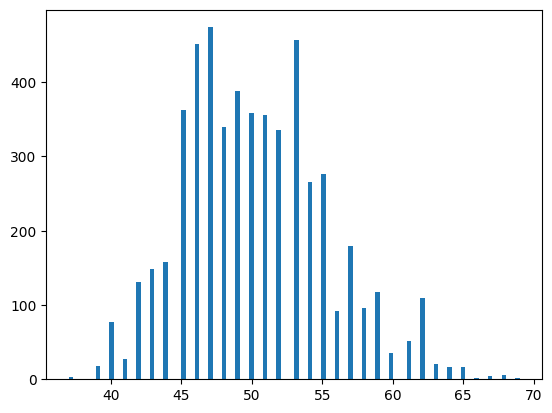

In [8]:
para_len = []
for i in range(len(data)):
    tmp = len(data[i]["L1"])+len(data[i]["L2"])+len(data[i]["L3"])+len(data[i]["H1"])+len(data[i]["H2"])+len(data[i]["H3"])
    para_len.append(tmp)
plt.hist(para_len, bins=100)

In [9]:
data[0]["Aseq"]["C"]

[{'name': 'ILE',
  'abbr': 'I',
  'pos': array([[ 81.858,  -7.199, 197.021],
         [ 81.735,  -6.449, 198.265],
         [ 80.284,  -6.421, 198.728],
         [ 79.74 ,  -5.362, 199.036]], dtype=float32)},
 {'name': 'ARG',
  'abbr': 'R',
  'pos': array([[ 79.66 ,  -7.596, 198.767],
         [ 78.278,  -7.837, 199.157],
         [ 77.269,  -7.526, 198.055],
         [ 76.075,  -7.745, 198.261]], dtype=float32)},
 {'name': 'CYS',
  'abbr': 'C',
  'pos': array([[ 77.695,  -7.022, 196.897],
         [ 76.793,  -6.774, 195.785],
         [ 77.323,  -7.296, 194.458],
         [ 76.538,  -7.469, 193.52 ]], dtype=float32)},
 {'name': 'ILE',
  'abbr': 'I',
  'pos': array([[ 78.63 ,  -7.552, 194.352],
         [ 79.196,  -8.074, 193.112],
         [ 78.916,  -9.554, 192.915],
         [ 78.921, -10.028, 191.772]], dtype=float32)},
 {'name': 'GLY',
  'abbr': 'G',
  'pos': array([[ 78.667, -10.296, 193.99 ],
         [ 78.411, -11.718, 193.885],
         [ 76.953, -12.063, 193.664],
         [ 

In [10]:
tmp = [data[0]["Aseq"][k] for k in data[0]["Aseq"]]
tmp = np.hstack(tmp)
# tmp = "/".join(tmp)
len(tmp)

392

(array([766., 232.,  43.,  92., 118., 241., 254., 229., 173., 133., 121.,
        171., 136., 121., 102., 136., 105., 152., 170., 104., 136.,  94.,
         73., 211., 128.,  95., 150.,  94.,  39., 148., 122.,  47.,  38.,
         41.,  25.,  18.,  20.,  17.,   7.,  10.,  23.,  15.,  19.,   6.,
          9.,   7.,  12.,   2.,   7.,   3.,  17.,  17.,   4.,  11.,  20.,
         12.,  11.,   4.,   2.,   9.,   5.,   7.,   5.,   7.,   6.,   0.,
          2.,   0.,   5.,   1.,   0.,   2.,   1.,   4.,   2.,   0.,   1.,
          0.,   1.,   0.,   0.,   1.,   0.,   2.,   0.,   1.,   1.,   0.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([   2.  ,   20.51,   39.02,   57.53,   76.04,   94.55,  113.06,
         131.57,  150.08,  168.59,  187.1 ,  205.61,  224.12,  242.63,
         261.14,  279.65,  298.16,  316.67,  335.18,  353.69,  372.2 ,
         390.71,  409.22,  427.73,  446.24,  464.75,  483.26,  501.77,
         520.28,  538.79,  557.3 ,

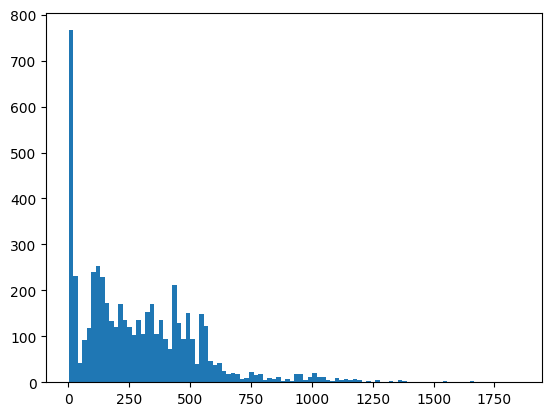

In [11]:
epi_len = []
for i in range(len(data)):
    tmp = [data[i]["Aseq"][k] for k in data[i]["Aseq"]]
    tmp = np.hstack(tmp)
    epi_len.append(len(tmp))
plt.hist(epi_len, bins=100)

(array([2.281e+03, 1.318e+03, 1.168e+03, 3.450e+02, 1.030e+02, 1.070e+02,
        3.800e+01, 1.100e+01, 7.000e+00, 2.000e+00]),
 array([   2. ,  187.1,  372.2,  557.3,  742.4,  927.5, 1112.6, 1297.7,
        1482.8, 1667.9, 1853. ]),
 <BarContainer object of 10 artists>)

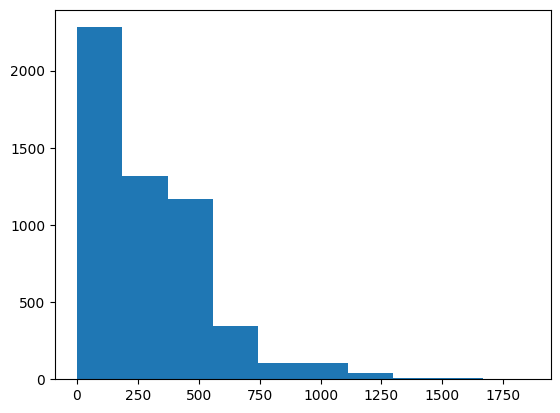

In [12]:
plt.hist(epi_len)

In [13]:
threshold = 400
print(len(epi_len))
sum([1 if epi_len[i]>threshold else 0 for i in range(len(epi_len))])

5380


1579

In [14]:
L1_len = []
L2_len = []
L3_len = []
H1_len = []
H2_len = []
H3_len = []
A_len = []

for i in range(len(data)):
    L1_len.append(len(data[i]["L1"]))
    L2_len.append(len(data[i]["L2"]))
    L3_len.append(len(data[i]["L3"]))
    H1_len.append(len(data[i]["H1"]))
    H2_len.append(len(data[i]["H2"]))
    H3_len.append(len(data[i]["H3"]))
    A_len.append(len("".join(data[i]["Aseq"])))
    # 3 antigen chains
    if len("".join(data[i]["Aseq"]))>=3:
        print(i)

49
96
117
128
179
241
407
438
488
517
527
532
554
609
615
672
813
1113
1176
1208
1216
1281
1322
1348
1381
1389
1397
1513
1590
1688
1694
1698
1702
1766
1781
1782
1796
2024
2088
2124
2131
2235
2247
2272
2386
2504
2627
2662
2693
2742
2808
2814
2898
2901
3062
3317
3331
3397
3486
3548
3598
3626
3667
3799
3920
3929
3988
4124
4222
4330
4334
4550
4626
4635
4643
4652
4666
4805
4895
4971
5035
5052
5077
5107
5113
5253
5278
5363


# debug

In [15]:
d = pickle.load(open("./data/processed_data_clip1_neg0.pkl", "rb"))
len(d)

7856

In [16]:
for i in range(len(d)):
    if "." in d[i][0] or "." in d[i][1]:
        print(i, d[i])

In [17]:
# need to remove redundant instances
# done below:
# 

## 1.2 dataset

## 1.3 Model

## 1.4 Training

In [18]:
# def my_pad_sequence(seqs):
#     max_len = max(list(map(lambda x:len(x), seqs)))
    
#     seqs = list(map(lambda x:"+"+x.strip("#")+"#"*(max_len-len(x.strip("#")))+"-", seqs))
    
#     return seqs

# def collate_fn(batch, mode=0):
    
#     # +ABCD-###
#     if mode==0:

#         paras = [b[0] for b in batch]
#         epis = [b[1] for b in batch]
#         labels = torch.hstack([b[2] for b in batch])
#         max_len = max(max(list(map(lambda x:len(x), paras))), max(list(map(lambda x:len(x), epis))))

#         paras = ["+"+i.strip("#")+"-"+"#"*(max_len-len(i.strip("#"))) for i in paras]
#         epis = ["+"+i.strip("#")+"-"+"#"*(max_len-len(i.strip("#"))) for i in epis]

#         new_batch = [paras, epis, labels]

#         return new_batch
    
#     # padding for six CDRs
#     if mode==1:
#         paras = [b[0] for b in batch]
#         paras = [(p.split("/"), max(list(map(lambda x:len(x), p.split("/"))))) for p in paras]
#         paras = list(map(my_pad_sequence, paras))
#         epis = [b[1] for b in batch]
#         labels = [b[2] for b in batch]
#         new_batch = [paras, epis, labels]

#         return new_batch

In [19]:
# config = {
#     'kfold': 10,          # 0 - full; 5 - 5fold; 10 - 10fold
#     'seq_clip_mode': 1,   # how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
#     'neg_sample_mode': 0, # how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
    
#     'model_name': 'lstm'
#     'embed_size': 32, 
#     'hidden': 64, 
    
#     'batch_size': 16, 
#     'clip_norm': 1
# }

In [25]:
para_len = 72
epi_len = 48
hidden = 64 #128 #64
embed_size = 32 #16 #64
kfold = 10


# how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
seq_clip_mode = 1 #0
# how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
neg_sample_mode = 0 #1

data_type = "seq" + str(seq_clip_mode) + "_" + "neg" + str(neg_sample_mode)

batch_size = 16 #128 #16
clip_norm = 1 # gradient clipping


# folds_path = None
folds_path = "./data/processed_data_clip1_neg0.pkl"


# model name
# model_name = "demo"
# model_name = "lstm"
# model_name = "mlp"
# model_name = "InteractTransformer"
# model_name = "InteractTransformerLSTM"
# model_name = "SetTransformer"
model_name = "SetModel"
# model_name = "SetModel_ablation"

os.makedirs("./results/SAbDab/{}/{}/".format(data_type, model_name), exist_ok=True)


for k_iter in range(kfold):
    
    print("=========================================================")
    print("fold {} as val set".format(k_iter))
    
    train_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                  seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                  kfold=kfold, holdout_fold=k_iter, is_train_test_full="train", is_shuffle=False, \
                                  folds_path=folds_path, save_path=None, K=48, data_augment=False, augment_ratio=0.5)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=collate_fn)

    test_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                 seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                 kfold=kfold, holdout_fold=k_iter, is_train_test_full="val", is_shuffle=False, \
                                 folds_path="./data/processed_data_clip{}_neg{}.pkl".format(seq_clip_mode, neg_sample_mode), \
                                 save_path=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, \
                                              collate_fn=collate_fn)
    
    if model_name=="demo":
        model = BiLSTM_demo(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        epochs = 100
        lr = 6e-5

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, hidden=64, num_layers=1, dropout=0.5, use_pretrain=False).cuda()
        epochs = 100
        lr = 6e-5
    
    elif model_name=="mlp":
        model = BiMLP(embed_size=embed_size, hidden=hidden, num_layers=1, dropout=0.1, use_pretrain=False).cuda()
        epochs = 100
        lr = 1e-2
    
    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3).cuda()
        epochs = 1000
        lr = 6e-5
        
    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=False).cuda()
        epochs = 150
        lr = 6e-5
        
    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=64, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5).cuda()
        epochs = 200
        lr = 1e-4
        
        
    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 1000
        lr = 3e-5
        
    elif model_name=="SetModel_ablation":
        model = SetModel_ablation(embed_size=32, 
                         hidden=64, 
                         num_layers=2, 
                         dropout=0.5, 
                         k4kmer=7, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         use_kmer_embed=True, 
                         use_seq_encoder=False, 
                         seq_encoder_type="lstm", 
                         num_heads=4, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 150
        lr = 6e-5

    else:
        pass
    
#     model = AlternateCoattnModel(embed_size=embed_size, seq_length=para_len, num_alternates=3, dropout=0.1).cuda()

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    best_val_loss = float("inf")
    
    for epoch in range(epochs):

        loss_tmp = []
        for i, (para, epi, label) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()

            pred = model(para, epi)

            loss = criterion(pred.view(-1), label.view(-1).cuda())

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

            optimizer.step()

            loss_tmp.append(loss.item())
        
        loss_buf.append(np.mean(loss_tmp))

    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])

        with torch.no_grad():

            model.eval()

            preds = []
            labels = []
            val_loss_tmp = []
            for i, (para, epi, label) in enumerate(tqdm(test_loader)):

                pred = model(para, epi)
                val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                preds.append(pred.detach().cpu().view(-1))
                labels.append(label.view(-1))
                val_loss_tmp.append(val_loss.item())
            
            preds = torch.hstack(preds).view(-1)
            labels = torch.hstack(labels).view(-1)

            acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
            f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
            auc = roc_auc_score(y_true=labels, y_score=preds)

            val_acc_buf.append(acc)
            val_f1_buf.append(f1)
            val_auc_buf.append(auc)
            val_loss_buf.append(np.mean(val_loss_tmp))

            print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc))
            
            if np.mean(val_loss_tmp)<best_val_loss:
                best_val_loss = np.mean(val_loss_tmp)
                torch.save(model, "./results/SAbDab/{}/{}/model_{}_best.pth".format(data_type, model_name, k_iter))
                np.save("./results/SAbDab/{}/{}/val_acc_{}_best.npy".format(data_type, model_name, k_iter), acc)
                np.save("./results/SAbDab/{}/{}/val_f1_{}_best.npy".format(data_type, model_name, k_iter), f1)
                np.save("./results/SAbDab/{}/{}/val_auc_{}_best.npy".format(data_type, model_name, k_iter), auc)

        torch.cuda.empty_cache()
                
        model.train()
        

    
    torch.save(model, "./results/SAbDab/{}/{}/model_{}.pth".format(data_type, model_name, k_iter))
    np.save("./results/SAbDab/{}/{}/loss_buf_{}.npy".format(data_type, model_name, k_iter), np.array(loss_buf))
    np.save("./results/SAbDab/{}/{}/val_loss_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_loss_buf))
    np.save("./results/SAbDab/{}/{}/val_acc_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_acc_buf))
    np.save("./results/SAbDab/{}/{}/val_f1_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_f1_buf))
    np.save("./results/SAbDab/{}/{}/val_auc_buf_{}.npy".format(data_type, model_name, k_iter), np.array(val_auc_buf))
    
    
#     break

fold 0 as val set
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
model parameters:  82979


100%|████████████████████████████████████████| 442/442 [00:01<00:00, 316.77it/s]


lr:  6e-05


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1086.13it/s]


Epoch 0: 
 Train Loss	0.6347 
 Val Loss	0.8089 
 Val Acc	0.5427 
 Val F1		0.0000 
 Val AUC	0.5129


100%|████████████████████████████████████████| 442/442 [00:01<00:00, 316.78it/s]


lr:  6e-05


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1050.75it/s]


Epoch 1: 
 Train Loss	0.6245 
 Val Loss	0.8066 
 Val Acc	0.5427 
 Val F1		0.0000 
 Val AUC	0.5241


 29%|███████████▌                            | 128/442 [00:00<00:00, 324.19it/s]


KeyboardInterrupt: 

In [ ]:
model

In [30]:
for batch in train_loader:
    break
batch

[['+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GGSISSGDSY/IYYSGST/ARHVGDLRVNDAFDI/SSNIGNNF/DSD/GTWDRSLSVVV-########',
  '+GFSLSSYP/IGTSGNI/ARGLYNDYTV/QSVYNKNY/SAS/LGSYDQAAHA-################',
  '+GFSLSSYP/IGTSGNI/ARGLYNDYTV/QSVYNKNY/SAS/LGSYDQAAHA-################',
  '+GYTFTAYY/INPNTGDT/AKDLTLMYVFDSGWARGAHDYYGMDV/NSDVGTFDL/EGS/SSYAGSVV-',
  '+GYTFTAYY/INPNTGDT/AKDLTLMYVFDSGWARGAHDYYGMDV/NSDVGTFDL/EGS/SSYAGSVV-',
  '+GDSISTNNG/INGRSGST/AFFWSTYYKRFDV/QSVDSR/DVS/HQENDWPWT-##############',
  '+GDSISTNNG/INGRSGST/AFFWSTYYKRFDV/QSVDSR/DVS/HQENDWPWT-##############',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-#########',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-#########',
  '+GFTFSDYG/ISNMAYSI/TRAIFDYAGYWYFDV/ESVEYYGTSL/GAS/QQSTKVPWT-#########',
  '+GFTFSDYG/ISNMAYSI/TRA

In [31]:
for batch in test_loader:
    break
batch

[['+GYTFTRYW/IYPGSNIT/AREGIYDGYFPLFPY/SSVSSGN/RTS/QQWSGYPWT-#####',
  '+GYSFTSYW/VYPGDSHT/TRSGFDYGNED/ESVDSYGNSF/RAS/QQSNEDPYT-######',
  '+GYSFTSYW/VYPGDSHT/TRSGFDYGNED/ESVDSYGNSF/RAS/QQSNEDPYT-######',
  '+GYTFTRFG/ISGYTGDT/VRNRVQMEVSPATQSTWYMDL/QDISRW/AAS/QQGSTFPYT-',
  '+GYTFTDYY/IVPNNGDT/ARFSNYVYPFDY/QDISNF/YTS/QQGNTLPLT-#########',
  '+GYTFTDYY/IVPNNGDT/ARFSNYVYPFDY/QDISNF/YTS/QQGNTLPLT-#########',
  '+GYTFTGYY/INPNSGDT/ARWDWGQYWFFDL/QSVRSSY/GAS/QHMYT-###########',
  '+GFPMSESYF/VIHTGTT/VRIRGGSSNWLDP/DSILRSAF/DDR/AAWNGRLSAFV-####',
  '+GFPMSESYF/VIHTGTT/VRIRGGSSNWLDP/DSILRSAF/DDR/AAWNGRLSAFV-####',
  '+GFTFSDAW/IRNKVNNHAT/TGLTFDY/ESVDNYGISS/AAS/QQSKGVPYT-########',
  '+GFTLSSYQ/ITGRGGVT/AKPALDSDQCGFPEAGCIDA/DSYY/GND/GAYDSSGGGGI-#',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-##',
  '+GFAFSSFG/ISSGSGTI/VRSIYYYGSSPFDF/KSLLHSNGNTY/RMS/MQHLEYPLT-##',
  '+GFTFSSYP/INNGGGNP/IRQYYGFDY/QTIVHSNGKIY/RVS/FQGSHVPWT-#######',
  '+GYTFTDYY/ISPYNGGT/VYDLYYFDY/QRISND/YAS/QQSNS

In [32]:
len(train_dataset), len(test_dataset)

(7065, 785)

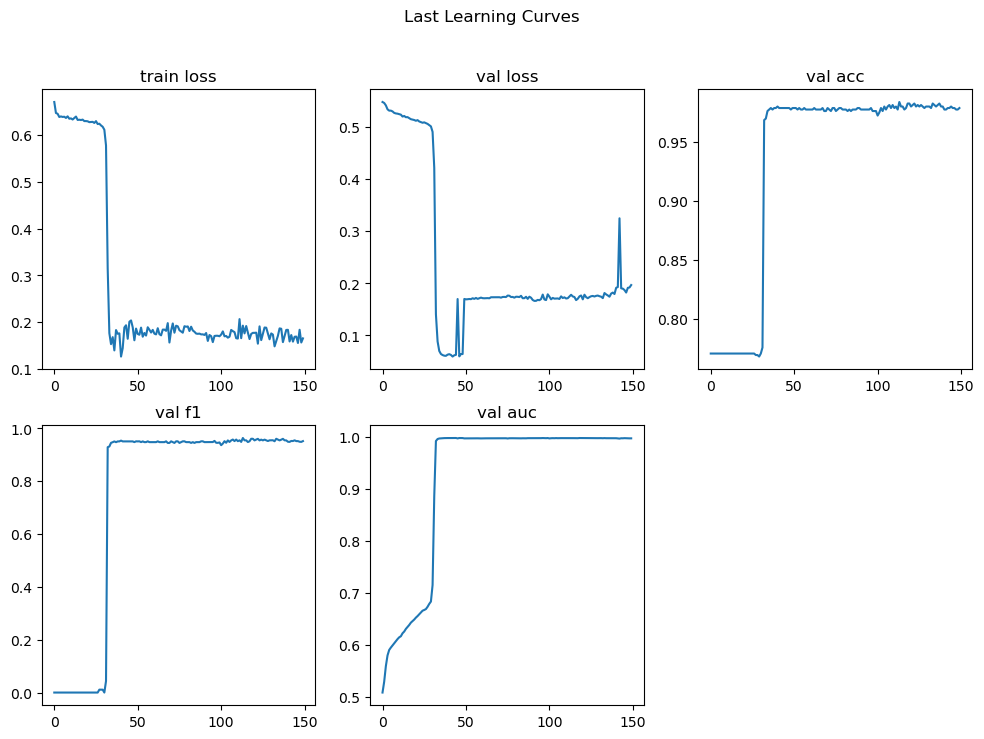

In [33]:
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.plot(loss_buf)
plt.title("train loss")

plt.subplot(232)
plt.plot(val_loss_buf)
plt.title("val loss")

plt.subplot(233)
plt.plot(val_acc_buf)
plt.title("val acc")

plt.subplot(234)
plt.plot(val_f1_buf)
plt.title("val f1")

plt.subplot(235)
plt.plot(val_auc_buf)
plt.title("val auc")

plt.suptitle("Last Learning Curves")
plt.show()

In [34]:
val_acc_mean = []
val_f1_mean = []
val_auc_mean = []

for i in range(10):
    
    val_acc_i = np.load("./results/SAbDab/{}/{}/val_acc_{}_best.npy".format(data_type, model_name, i))
    val_acc_mean.append(val_acc_i)
    
    val_f1_i = np.load("./results/SAbDab/{}/{}/val_f1_{}_best.npy".format(data_type, model_name, i))
    val_f1_mean.append(val_f1_i)
    
    val_auc_i = np.load("./results/SAbDab/{}/{}/val_auc_{}_best.npy".format(data_type, model_name, i))
    val_auc_mean.append(val_auc_i)
    
    break
    
print("val acc mean: ", np.mean(val_acc_mean))
print("val f1 mean: ", np.mean(val_f1_mean))
print("val auc mean: ", np.mean(val_auc_mean))

val acc mean:  0.9732484076433121
val f1 mean:  0.9703808180535965
val auc mean:  0.9960178900702265


BiLSTM
- val acc mean:  0.9752300070771409
- val f1 mean:  0.9596004547190097
- val auc mean:  0.9961982339896467

demo - BiLSTM + remove "/"
- val acc mean:  0.9753715498938429
- val f1 mean:  0.9598416847843452
- val auc mean:  0.9965583867631231

InteractTransformer
- non-convergence @ first 10 epochs

InteractTransformerLSTM
- val acc mean:  0.9732484076433121
- val f1 mean:  0.9703808180535965
- val auc mean:  0.9960178900702265

SetTransformer
- val acc mean:  0.6771408351026185
- val f1 mean:  0.04578574402452007
- val auc mean:  0.5926709617479097

SetModel
- val acc mean:  0.9732484076433122
- val f1 mean:  0.9560846468263452
- val auc mean:  0.9952099378558822

SetModel_ablation
- use kmer & no seq_encoder
- val acc mean:  0.6771408351026186
- val f1 mean:  0.07555667240028481
- val auc mean:  0.6110399605027198

### BiLSTM

5fold

SAbDab: random AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5003266448903407
- val f1 mean:  0.4014024178914616


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.7940270648623425
- val f1 mean:  0.765332158051016

use_pretrain
seq1 neg0
- 

### InteractTransformer

10fold

- CoV-AbDab [参数量 115571]
- val acc mean:  0.735483870967742
- val f1 mean:  0.8428165297819017

5fold

SAbDab: random AA for epitope seq_clip_mode=0

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5050863275781614
- val f1 mean:  0.26889531502460473
- 应当比随机序列做样本更难，因为抗体序列间的差异很小，只在关键区域有差异；其次是随机的AA所以序列不完整且没有生物意义，导致难分类；


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.8476901539897341
- val f1 mean:  0.8243978319230338
- 随机序列作为负样本用于测试可能不鲁棒，模型可能学得烂但测得高 -- 如何评估？-> 取k近邻的AA为epitope，该数据应当具有意义

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5047130191320578
- val f1 mean:  0.3031313875079131


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.7128324778348111
- val f1 mean:  0.6669602710083161
- 存在过拟合导致崩掉的现象 (e.g. epoch1、epoch10)
- share modules [参数量 634930]
- val acc mean:  0.5620158656089593
- val f1 mean:  0.5473767284795179

### BiInteractTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5009799346710219
- val f1 mean:  0.44771116164979696


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.6001866542230518
- val f1 mean:  0.7264313877322651
- share modules [参数量 1267059]
- val acc mean:  0.8121325244983668
- val f1 mean:  0.8445375055084579

### InteractCoattnTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- [参数量 367858]
- val acc mean:  0.50648623425105
- val f1 mean:  0.47167367326203075


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.561455902939804
- val f1 mean:  0.4968735319816034
- share modules [参数量 647410]
- val acc mean:  0.7028464769015399
- val f1 mean:  0.6089746640207852
- share modules [参数量 251122]
- val acc mean:  0.643210452636491
- val f1 mean:  0.6049936565494491

### SetTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0
- val acc mean:  0.5085394307046197
- val f1 mean:  0.45360035038396046


- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.9564162389174055
- val f1 mean:  0.9517408054109368

### SetCoAttnTransformer

5fold

SAbDab: k-nearest AA for epitope seq_clip_mode=1

- 负样本-数据集中随机采样 neg_sample_mode=0



- 负样本-随机序列 neg_sample_mode=1
- val acc mean:  0.9985067662155857
- val f1 mean:  0.9985067657686753

### AlternateCoAttnModel

1 & 0
- val acc mean:  0.5012599160055997
- val f1 mean:  0.24524917697199666

# full training

In [18]:
def evaluate(model_name, data_type="seq1_neg0", use_pair=False):
    
    print("======================================")
    print("=================={}================".format(model_name))
    print("======================================")
    
    if use_pair==False:
        val_acc = np.load("./results/SAbDab/full/{}/{}/val_acc_buf.npy".format(data_type, model_name))
        val_f1 = np.load("./results/SAbDab/full/{}/{}/val_f1_buf.npy".format(data_type, model_name))
        val_auc = np.load("./results/SAbDab/full/{}/{}/val_auc_buf.npy".format(data_type, model_name))
        
    loss_buf = np.load("./results/SAbDab/full/{}/{}/loss_buf.npy".format(data_type, model_name))
    val_loss_buf = np.load("./results/SAbDab/full/{}/{}/val_loss_buf.npy".format(data_type, model_name))
    
    plt.figure(figsize=(12,8))

    plt.subplot(231)
    plt.plot(loss_buf)
    plt.title("train loss")

    plt.subplot(232)
    plt.plot(val_loss_buf)
    plt.title("val loss")

    if use_pair==False:
    
        plt.subplot(233)
        plt.plot(val_acc_buf)
        plt.title("val acc")

        plt.subplot(234)
        plt.plot(val_f1_buf)
        plt.title("val f1")

        plt.subplot(235)
        plt.plot(val_auc_buf)
        plt.title("val auc")

    plt.suptitle("Last Learning Curves")
    plt.show()


    if use_pair==False:
        val_acc = np.load("./results/SAbDab/full/{}/{}/val_acc_best.npy".format(data_type, model_name))

        val_f1 = np.load("./results/SAbDab/full/{}/{}/val_f1_best.npy".format(data_type, model_name))

        val_auc = np.load("./results/SAbDab/full/{}/{}/val_auc_best.npy".format(data_type, model_name))


        print("val acc mean: ", np.mean(val_acc))
        print("val f1 mean: ", np.mean(val_f1))
        print("val auc mean: ", np.mean(val_auc))

training SetCoAttnTransformer on SAbDab-full
loading preprocessed data from ./data/processed_data_clip1_neg0.pkl
model parameters:  882209
Epoch 0


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.06it/s]


Epoch 0: 
 Train Loss	0.6514 
 Val Loss	1.0716 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4653
Epoch 1


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.85it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.40it/s]


Epoch 1: 
 Train Loss	0.6463 
 Val Loss	1.3045 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4636
Epoch 2


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.96it/s]


Epoch 2: 
 Train Loss	0.6464 
 Val Loss	1.6057 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4750
Epoch 3


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.61it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.83it/s]


Epoch 3: 
 Train Loss	0.6448 
 Val Loss	1.5621 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.5227
Epoch 4


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.03it/s]


Epoch 4: 
 Train Loss	0.6429 
 Val Loss	1.6482 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.5046
Epoch 5


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 430.94it/s]


Epoch 5: 
 Train Loss	0.6449 
 Val Loss	1.7069 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4679
Epoch 6


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.39it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.92it/s]


Epoch 6: 
 Train Loss	0.6459 
 Val Loss	1.7289 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4694
Epoch 7


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.15it/s]


Epoch 7: 
 Train Loss	0.6459 
 Val Loss	1.7109 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4885
Epoch 8


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.42it/s]


Epoch 8: 
 Train Loss	0.6469 
 Val Loss	1.7295 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4857
Epoch 9


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.85it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.09it/s]


Epoch 9: 
 Train Loss	0.6473 
 Val Loss	1.7646 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4493
Epoch 10


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.98it/s]


Epoch 10: 
 Train Loss	0.6477 
 Val Loss	1.8052 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.5008
Epoch 11


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.00it/s]


Epoch 11: 
 Train Loss	0.6486 
 Val Loss	1.8241 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4631
Epoch 12


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.94it/s]


Epoch 12: 
 Train Loss	0.6499 
 Val Loss	1.8103 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4646
Epoch 13


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.98it/s]


Epoch 13: 
 Train Loss	0.6506 
 Val Loss	1.8559 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.5210
Epoch 14


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.78it/s]


Epoch 14: 
 Train Loss	0.6506 
 Val Loss	1.8423 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.5025
Epoch 15


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.21it/s]


Epoch 15: 
 Train Loss	0.6504 
 Val Loss	1.8262 
 Val Acc	0.2613 
 Val F1		0.0000 
 Val AUC	0.5085
Epoch 16


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.00it/s]


Epoch 16: 
 Train Loss	0.6500 
 Val Loss	1.8048 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4951
Epoch 17


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.05it/s]


Epoch 17: 
 Train Loss	0.6508 
 Val Loss	1.7927 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4856
Epoch 18


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.70it/s]


Epoch 18: 
 Train Loss	0.6503 
 Val Loss	1.7765 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4780
Epoch 19


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.11it/s]


Epoch 19: 
 Train Loss	0.6502 
 Val Loss	1.7787 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4945
Epoch 20


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.10it/s]


Epoch 20: 
 Train Loss	0.6496 
 Val Loss	1.7618 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4830
Epoch 21


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.16it/s]


Epoch 21: 
 Train Loss	0.6492 
 Val Loss	1.7479 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4710
Epoch 22


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.92it/s]


Epoch 22: 
 Train Loss	0.6484 
 Val Loss	1.7354 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4453
Epoch 23


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.99it/s]


Epoch 23: 
 Train Loss	0.6475 
 Val Loss	1.7253 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.5033
Epoch 24


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.97it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.10it/s]


Epoch 24: 
 Train Loss	0.6466 
 Val Loss	1.7272 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4644
Epoch 25


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.24it/s]


Epoch 25: 
 Train Loss	0.6468 
 Val Loss	1.7227 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4492
Epoch 26


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.16it/s]


Epoch 26: 
 Train Loss	0.6459 
 Val Loss	1.7088 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4713
Epoch 27


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.12it/s]


Epoch 27: 
 Train Loss	0.6450 
 Val Loss	1.7061 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4704
Epoch 28


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.50it/s]


Epoch 28: 
 Train Loss	0.6444 
 Val Loss	1.7000 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4421
Epoch 29


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.21it/s]


Epoch 29: 
 Train Loss	0.6433 
 Val Loss	1.6973 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4473
Epoch 30


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.99it/s]


Epoch 30: 
 Train Loss	0.6423 
 Val Loss	1.6966 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4569
Epoch 31


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.92it/s]


Epoch 31: 
 Train Loss	0.6415 
 Val Loss	1.6892 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4597
Epoch 32


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.21it/s]


Epoch 32: 
 Train Loss	0.6404 
 Val Loss	1.6915 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4575
Epoch 33


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.79it/s]


Epoch 33: 
 Train Loss	0.6392 
 Val Loss	1.7074 
 Val Acc	0.2710 
 Val F1		0.0174 
 Val AUC	0.4270
Epoch 34


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.91it/s]


Epoch 34: 
 Train Loss	0.6384 
 Val Loss	1.7145 
 Val Acc	0.2645 
 Val F1		0.0000 
 Val AUC	0.4597
Epoch 35


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.75it/s]


Epoch 35: 
 Train Loss	0.6374 
 Val Loss	1.7255 
 Val Acc	0.2806 
 Val F1		0.0429 
 Val AUC	0.4437
Epoch 36


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.21it/s]


Epoch 36: 
 Train Loss	0.6363 
 Val Loss	1.7506 
 Val Acc	0.2806 
 Val F1		0.0429 
 Val AUC	0.4834
Epoch 37


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.60it/s]


Epoch 37: 
 Train Loss	0.6356 
 Val Loss	1.7682 
 Val Acc	0.2677 
 Val F1		0.0087 
 Val AUC	0.4476
Epoch 38


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.41it/s]


Epoch 38: 
 Train Loss	0.6347 
 Val Loss	1.7698 
 Val Acc	0.2710 
 Val F1		0.0174 
 Val AUC	0.4564
Epoch 39


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.92it/s]


Epoch 39: 
 Train Loss	0.6336 
 Val Loss	1.7739 
 Val Acc	0.2645 
 Val F1		0.0087 
 Val AUC	0.4661
Epoch 40


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.53it/s]


Epoch 40: 
 Train Loss	0.6323 
 Val Loss	1.7780 
 Val Acc	0.2806 
 Val F1		0.0591 
 Val AUC	0.4318
Epoch 41


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.54it/s]


Epoch 41: 
 Train Loss	0.6316 
 Val Loss	1.7847 
 Val Acc	0.2613 
 Val F1		0.0000 
 Val AUC	0.4783
Epoch 42


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.23it/s]


Epoch 42: 
 Train Loss	0.6303 
 Val Loss	1.7924 
 Val Acc	0.2613 
 Val F1		0.0000 
 Val AUC	0.4771
Epoch 43


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.13it/s]


Epoch 43: 
 Train Loss	0.6294 
 Val Loss	1.8037 
 Val Acc	0.2613 
 Val F1		0.0255 
 Val AUC	0.4749
Epoch 44


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.16it/s]


Epoch 44: 
 Train Loss	0.6281 
 Val Loss	1.8253 
 Val Acc	0.2774 
 Val F1		0.0588 
 Val AUC	0.4637
Epoch 45


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 433.60it/s]


Epoch 45: 
 Train Loss	0.6267 
 Val Loss	1.8352 
 Val Acc	0.2677 
 Val F1		0.0884 
 Val AUC	0.4375
Epoch 46


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.61it/s]


Epoch 46: 
 Train Loss	0.6260 
 Val Loss	1.8659 
 Val Acc	0.2677 
 Val F1		0.0581 
 Val AUC	0.4657
Epoch 47


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.35it/s]


Epoch 47: 
 Train Loss	0.6251 
 Val Loss	1.8856 
 Val Acc	0.2742 
 Val F1		0.0891 
 Val AUC	0.4551
Epoch 48


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.23it/s]


Epoch 48: 
 Train Loss	0.6242 
 Val Loss	1.9246 
 Val Acc	0.2935 
 Val F1		0.1205 
 Val AUC	0.4537
Epoch 49


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.67it/s]


Epoch 49: 
 Train Loss	0.6236 
 Val Loss	1.9333 
 Val Acc	0.3161 
 Val F1		0.1970 
 Val AUC	0.4512
Epoch 50


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.09it/s]


Epoch 50: 
 Train Loss	0.6229 
 Val Loss	1.9485 
 Val Acc	0.3484 
 Val F1		0.3082 
 Val AUC	0.4285
Epoch 51


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.83it/s]


Epoch 51: 
 Train Loss	0.6220 
 Val Loss	1.9574 
 Val Acc	0.3290 
 Val F1		0.2518 
 Val AUC	0.4366
Epoch 52


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.39it/s]


Epoch 52: 
 Train Loss	0.6212 
 Val Loss	1.9957 
 Val Acc	0.3194 
 Val F1		0.2383 
 Val AUC	0.4535
Epoch 53


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.55it/s]


Epoch 53: 
 Train Loss	0.6199 
 Val Loss	2.0183 
 Val Acc	0.3194 
 Val F1		0.2699 
 Val AUC	0.4275
Epoch 54


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.75it/s]


Epoch 54: 
 Train Loss	0.6187 
 Val Loss	2.0435 
 Val Acc	0.3226 
 Val F1		0.2446 
 Val AUC	0.4527
Epoch 55


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.10it/s]


Epoch 55: 
 Train Loss	0.6176 
 Val Loss	2.0636 
 Val Acc	0.3484 
 Val F1		0.3355 
 Val AUC	0.4516
Epoch 56


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.63it/s]


Epoch 56: 
 Train Loss	0.6168 
 Val Loss	2.1014 
 Val Acc	0.3903 
 Val F1		0.4038 
 Val AUC	0.4437
Epoch 57


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.50it/s]


Epoch 57: 
 Train Loss	0.6158 
 Val Loss	2.1245 
 Val Acc	0.3484 
 Val F1		0.3399 
 Val AUC	0.4512
Epoch 58


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.24it/s]


Epoch 58: 
 Train Loss	0.6144 
 Val Loss	2.1644 
 Val Acc	0.3419 
 Val F1		0.2917 
 Val AUC	0.4613
Epoch 59


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.34it/s]


Epoch 59: 
 Train Loss	0.6134 
 Val Loss	2.1872 
 Val Acc	0.3387 
 Val F1		0.3234 
 Val AUC	0.4592
Epoch 60


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 343.35it/s]


Epoch 60: 
 Train Loss	0.6120 
 Val Loss	2.2021 
 Val Acc	0.3419 
 Val F1		0.3289 
 Val AUC	0.4661
Epoch 61


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.86it/s]


Epoch 61: 
 Train Loss	0.6104 
 Val Loss	2.2194 
 Val Acc	0.3419 
 Val F1		0.3200 
 Val AUC	0.4647
Epoch 62


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 404.42it/s]


Epoch 62: 
 Train Loss	0.6090 
 Val Loss	2.2515 
 Val Acc	0.3548 
 Val F1		0.3103 
 Val AUC	0.4564
Epoch 63


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.79it/s]


Epoch 63: 
 Train Loss	0.6073 
 Val Loss	2.2824 
 Val Acc	0.3581 
 Val F1		0.3254 
 Val AUC	0.4733
Epoch 64


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 400.18it/s]


Epoch 64: 
 Train Loss	0.6061 
 Val Loss	2.3063 
 Val Acc	0.3806 
 Val F1		0.3962 
 Val AUC	0.4746
Epoch 65


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.68it/s]


Epoch 65: 
 Train Loss	0.6043 
 Val Loss	2.3397 
 Val Acc	0.3548 
 Val F1		0.3243 
 Val AUC	0.4635
Epoch 66


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.76it/s]


Epoch 66: 
 Train Loss	0.6022 
 Val Loss	2.3650 
 Val Acc	0.3645 
 Val F1		0.3367 
 Val AUC	0.4950
Epoch 67


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.58it/s]


Epoch 67: 
 Train Loss	0.6005 
 Val Loss	2.3955 
 Val Acc	0.3516 
 Val F1		0.3537 
 Val AUC	0.4504
Epoch 68


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.04it/s]


Epoch 68: 
 Train Loss	0.5993 
 Val Loss	2.4356 
 Val Acc	0.3968 
 Val F1		0.4026 
 Val AUC	0.4926
Epoch 69


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.96it/s]


Epoch 69: 
 Train Loss	0.5984 
 Val Loss	2.4672 
 Val Acc	0.3742 
 Val F1		0.3822 
 Val AUC	0.4827
Epoch 70


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.01it/s]


Epoch 70: 
 Train Loss	0.5970 
 Val Loss	2.5085 
 Val Acc	0.3581 
 Val F1		0.3300 
 Val AUC	0.4801
Epoch 71


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.98it/s]


Epoch 71: 
 Train Loss	0.5961 
 Val Loss	2.5439 
 Val Acc	0.3742 
 Val F1		0.4012 
 Val AUC	0.4489
Epoch 72


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.03it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.63it/s]


Epoch 72: 
 Train Loss	0.5948 
 Val Loss	2.5672 
 Val Acc	0.3484 
 Val F1		0.3399 
 Val AUC	0.4835
Epoch 73


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.39it/s]


Epoch 73: 
 Train Loss	0.5930 
 Val Loss	2.5967 
 Val Acc	0.3710 
 Val F1		0.3689 
 Val AUC	0.4849
Epoch 74


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.87it/s]


Epoch 74: 
 Train Loss	0.5911 
 Val Loss	2.6231 
 Val Acc	0.3903 
 Val F1		0.4358 
 Val AUC	0.4663
Epoch 75


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.88it/s]


Epoch 75: 
 Train Loss	0.5895 
 Val Loss	2.6644 
 Val Acc	0.3935 
 Val F1		0.3974 
 Val AUC	0.4990
Epoch 76


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.04it/s]


Epoch 76: 
 Train Loss	0.5882 
 Val Loss	2.6941 
 Val Acc	0.3903 
 Val F1		0.4038 
 Val AUC	0.4865
Epoch 77


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.18it/s]


Epoch 77: 
 Train Loss	0.5867 
 Val Loss	2.7198 
 Val Acc	0.3935 
 Val F1		0.4125 
 Val AUC	0.5046
Epoch 78


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.76it/s]


Epoch 78: 
 Train Loss	0.5854 
 Val Loss	2.7552 
 Val Acc	0.3935 
 Val F1		0.4051 
 Val AUC	0.4595
Epoch 79


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.34it/s]


Epoch 79: 
 Train Loss	0.5838 
 Val Loss	2.7817 
 Val Acc	0.3903 
 Val F1		0.4075 
 Val AUC	0.4780
Epoch 80


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.05it/s]


Epoch 80: 
 Train Loss	0.5824 
 Val Loss	2.8302 
 Val Acc	0.4000 
 Val F1		0.4151 
 Val AUC	0.4922
Epoch 81


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.26it/s]


Epoch 81: 
 Train Loss	0.5812 
 Val Loss	2.8638 
 Val Acc	0.3774 
 Val F1		0.3912 
 Val AUC	0.4859
Epoch 82


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.48it/s]


Epoch 82: 
 Train Loss	0.5798 
 Val Loss	2.9135 
 Val Acc	0.4129 
 Val F1		0.4129 
 Val AUC	0.4963
Epoch 83


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.11it/s]


Epoch 83: 
 Train Loss	0.5786 
 Val Loss	2.9426 
 Val Acc	0.4000 
 Val F1		0.4114 
 Val AUC	0.4795
Epoch 84


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.62it/s]


Epoch 84: 
 Train Loss	0.5773 
 Val Loss	2.9955 
 Val Acc	0.3839 
 Val F1		0.3779 
 Val AUC	0.4653
Epoch 85


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 390.47it/s]


Epoch 85: 
 Train Loss	0.5759 
 Val Loss	3.0367 
 Val Acc	0.4323 
 Val F1		0.4943 
 Val AUC	0.4836
Epoch 86


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 404.79it/s]


Epoch 86: 
 Train Loss	0.5751 
 Val Loss	3.0462 
 Val Acc	0.4387 
 Val F1		0.5085 
 Val AUC	0.4780
Epoch 87


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.04it/s]


Epoch 87: 
 Train Loss	0.5733 
 Val Loss	3.0715 
 Val Acc	0.3903 
 Val F1		0.4185 
 Val AUC	0.4564
Epoch 88


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.90it/s]


Epoch 88: 
 Train Loss	0.5722 
 Val Loss	3.0942 
 Val Acc	0.4000 
 Val F1		0.4329 
 Val AUC	0.4699
Epoch 89


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 401.94it/s]


Epoch 89: 
 Train Loss	0.5710 
 Val Loss	3.1173 
 Val Acc	0.4258 
 Val F1		0.4826 
 Val AUC	0.4858
Epoch 90


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.75it/s]


Epoch 90: 
 Train Loss	0.5697 
 Val Loss	3.1471 
 Val Acc	0.4032 
 Val F1		0.4543 
 Val AUC	0.4573
Epoch 91


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 398.80it/s]


Epoch 91: 
 Train Loss	0.5685 
 Val Loss	3.2143 
 Val Acc	0.3710 
 Val F1		0.3963 
 Val AUC	0.4349
Epoch 92


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.41it/s]


Epoch 92: 
 Train Loss	0.5675 
 Val Loss	3.2631 
 Val Acc	0.4323 
 Val F1		0.4854 
 Val AUC	0.4746
Epoch 93


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.87it/s]


Epoch 93: 
 Train Loss	0.5660 
 Val Loss	3.3028 
 Val Acc	0.4226 
 Val F1		0.4688 
 Val AUC	0.4684
Epoch 94


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 404.41it/s]


Epoch 94: 
 Train Loss	0.5644 
 Val Loss	3.3349 
 Val Acc	0.4323 
 Val F1		0.5056 
 Val AUC	0.4544
Epoch 95


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.60it/s]


Epoch 95: 
 Train Loss	0.5627 
 Val Loss	3.3528 
 Val Acc	0.4258 
 Val F1		0.4639 
 Val AUC	0.4574
Epoch 96


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.62it/s]


Epoch 96: 
 Train Loss	0.5619 
 Val Loss	3.4119 
 Val Acc	0.3742 
 Val F1		0.4085 
 Val AUC	0.4595
Epoch 97


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.76it/s]


Epoch 97: 
 Train Loss	0.5607 
 Val Loss	3.4458 
 Val Acc	0.4258 
 Val F1		0.4795 
 Val AUC	0.4878
Epoch 98


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 436.46it/s]


Epoch 98: 
 Train Loss	0.5593 
 Val Loss	3.4765 
 Val Acc	0.4355 
 Val F1		0.5125 
 Val AUC	0.4523
Epoch 99


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.66it/s]


Epoch 99: 
 Train Loss	0.5581 
 Val Loss	3.5138 
 Val Acc	0.3839 
 Val F1		0.4299 
 Val AUC	0.4456
Epoch 100


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.16it/s]


Epoch 100: 
 Train Loss	0.5568 
 Val Loss	3.5585 
 Val Acc	0.4097 
 Val F1		0.4633 
 Val AUC	0.4527
Epoch 101


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 435.04it/s]


Epoch 101: 
 Train Loss	0.5557 
 Val Loss	3.6007 
 Val Acc	0.4000 
 Val F1		0.4561 
 Val AUC	0.4391
Epoch 102


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.97it/s]


Epoch 102: 
 Train Loss	0.5544 
 Val Loss	3.6455 
 Val Acc	0.3935 
 Val F1		0.4438 
 Val AUC	0.4327
Epoch 103


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.88it/s]


Epoch 103: 
 Train Loss	0.5530 
 Val Loss	3.6761 
 Val Acc	0.4226 
 Val F1		0.4958 
 Val AUC	0.4551
Epoch 104


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.15it/s]


Epoch 104: 
 Train Loss	0.5520 
 Val Loss	3.7085 
 Val Acc	0.4452 
 Val F1		0.5249 
 Val AUC	0.4531
Epoch 105


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.77it/s]


Epoch 105: 
 Train Loss	0.5509 
 Val Loss	3.7389 
 Val Acc	0.4548 
 Val F1		0.5420 
 Val AUC	0.4610
Epoch 106


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.79it/s]


Epoch 106: 
 Train Loss	0.5497 
 Val Loss	3.7687 
 Val Acc	0.4581 
 Val F1		0.5532 
 Val AUC	0.4426
Epoch 107


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 432.46it/s]


Epoch 107: 
 Train Loss	0.5485 
 Val Loss	3.7980 
 Val Acc	0.3742 
 Val F1		0.4360 
 Val AUC	0.4188
Epoch 108


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.56it/s]


Epoch 108: 
 Train Loss	0.5479 
 Val Loss	3.8505 
 Val Acc	0.4355 
 Val F1		0.4986 
 Val AUC	0.4594
Epoch 109


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.81it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 430.26it/s]


Epoch 109: 
 Train Loss	0.5469 
 Val Loss	3.8697 
 Val Acc	0.4548 
 Val F1		0.5420 
 Val AUC	0.4529
Epoch 110


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 433.88it/s]


Epoch 110: 
 Train Loss	0.5461 
 Val Loss	3.9297 
 Val Acc	0.4065 
 Val F1		0.4651 
 Val AUC	0.4369
Epoch 111


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 430.96it/s]


Epoch 111: 
 Train Loss	0.5450 
 Val Loss	3.9675 
 Val Acc	0.4194 
 Val F1		0.4828 
 Val AUC	0.4674
Epoch 112


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.29it/s]


Epoch 112: 
 Train Loss	0.5444 
 Val Loss	3.9999 
 Val Acc	0.4419 
 Val F1		0.5154 
 Val AUC	0.4680
Epoch 113


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.57it/s]


Epoch 113: 
 Train Loss	0.5432 
 Val Loss	4.0207 
 Val Acc	0.4774 
 Val F1		0.5781 
 Val AUC	0.4682
Epoch 114


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.34it/s]


Epoch 114: 
 Train Loss	0.5420 
 Val Loss	4.0474 
 Val Acc	0.5097 
 Val F1		0.6293 
 Val AUC	0.4754
Epoch 115


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.57it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 433.44it/s]


Epoch 115: 
 Train Loss	0.5415 
 Val Loss	4.0935 
 Val Acc	0.4548 
 Val F1		0.5517 
 Val AUC	0.4602
Epoch 116


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.12it/s]


Epoch 116: 
 Train Loss	0.5404 
 Val Loss	4.1409 
 Val Acc	0.4516 
 Val F1		0.5330 
 Val AUC	0.4619
Epoch 117


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 434.99it/s]


Epoch 117: 
 Train Loss	0.5394 
 Val Loss	4.1685 
 Val Acc	0.4032 
 Val F1		0.4478 
 Val AUC	0.4519
Epoch 118


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.67it/s]


Epoch 118: 
 Train Loss	0.5388 
 Val Loss	4.1902 
 Val Acc	0.4839 
 Val F1		0.5699 
 Val AUC	0.4723
Epoch 119


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.62it/s]


Epoch 119: 
 Train Loss	0.5382 
 Val Loss	4.2029 
 Val Acc	0.4774 
 Val F1		0.5622 
 Val AUC	0.5022
Epoch 120


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 434.74it/s]


Epoch 120: 
 Train Loss	0.5378 
 Val Loss	4.2216 
 Val Acc	0.4677 
 Val F1		0.5692 
 Val AUC	0.4627
Epoch 121


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.03it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.31it/s]


Epoch 121: 
 Train Loss	0.5369 
 Val Loss	4.2505 
 Val Acc	0.4548 
 Val F1		0.5158 
 Val AUC	0.4976
Epoch 122


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.37it/s]


Epoch 122: 
 Train Loss	0.5360 
 Val Loss	4.2836 
 Val Acc	0.4839 
 Val F1		0.5556 
 Val AUC	0.4866
Epoch 123


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.81it/s]


Epoch 123: 
 Train Loss	0.5361 
 Val Loss	4.3305 
 Val Acc	0.4581 
 Val F1		0.5556 
 Val AUC	0.4366
Epoch 124


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.56it/s]


Epoch 124: 
 Train Loss	0.5351 
 Val Loss	4.3625 
 Val Acc	0.4387 
 Val F1		0.5372 
 Val AUC	0.4433
Epoch 125


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 432.52it/s]


Epoch 125: 
 Train Loss	0.5342 
 Val Loss	4.3991 
 Val Acc	0.4129 
 Val F1		0.4551 
 Val AUC	0.4847
Epoch 126


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 430.88it/s]


Epoch 126: 
 Train Loss	0.5336 
 Val Loss	4.4476 
 Val Acc	0.4129 
 Val F1		0.4518 
 Val AUC	0.4837
Epoch 127


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.22it/s]


Epoch 127: 
 Train Loss	0.5327 
 Val Loss	4.4872 
 Val Acc	0.4548 
 Val F1		0.5370 
 Val AUC	0.4849
Epoch 128


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.83it/s]


Epoch 128: 
 Train Loss	0.5332 
 Val Loss	4.5365 
 Val Acc	0.4129 
 Val F1		0.4615 
 Val AUC	0.4618
Epoch 129


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.09it/s]


Epoch 129: 
 Train Loss	0.5331 
 Val Loss	4.5787 
 Val Acc	0.4323 
 Val F1		0.5243 
 Val AUC	0.4250
Epoch 130


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.95it/s]


Epoch 130: 
 Train Loss	0.5327 
 Val Loss	4.6372 
 Val Acc	0.4452 
 Val F1		0.5301 
 Val AUC	0.4298
Epoch 131


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 430.45it/s]


Epoch 131: 
 Train Loss	0.5322 
 Val Loss	4.6748 
 Val Acc	0.4226 
 Val F1		0.5096 
 Val AUC	0.4307
Epoch 132


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.49it/s]


Epoch 132: 
 Train Loss	0.5324 
 Val Loss	4.7200 
 Val Acc	0.4097 
 Val F1		0.4959 
 Val AUC	0.4268
Epoch 133


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.76it/s]


Epoch 133: 
 Train Loss	0.5317 
 Val Loss	4.7637 
 Val Acc	0.4290 
 Val F1		0.4957 
 Val AUC	0.4648
Epoch 134


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.07it/s]


Epoch 134: 
 Train Loss	0.5314 
 Val Loss	4.7978 
 Val Acc	0.4839 
 Val F1		0.5745 
 Val AUC	0.4651
Epoch 135


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.26it/s]


Epoch 135: 
 Train Loss	0.5310 
 Val Loss	4.8379 
 Val Acc	0.4097 
 Val F1		0.4726 
 Val AUC	0.4375
Epoch 136


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 436.10it/s]


Epoch 136: 
 Train Loss	0.5310 
 Val Loss	4.8691 
 Val Acc	0.5097 
 Val F1		0.6021 
 Val AUC	0.4820
Epoch 137


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 437.31it/s]


Epoch 137: 
 Train Loss	0.5315 
 Val Loss	4.9155 
 Val Acc	0.4516 
 Val F1		0.5170 
 Val AUC	0.4848
Epoch 138


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.42it/s]


Epoch 138: 
 Train Loss	0.5312 
 Val Loss	4.9448 
 Val Acc	0.4516 
 Val F1		0.5405 
 Val AUC	0.4399
Epoch 139


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.72it/s]


Epoch 139: 
 Train Loss	0.5313 
 Val Loss	5.0133 
 Val Acc	0.4323 
 Val F1		0.5028 
 Val AUC	0.4324
Epoch 140


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.74it/s]


Epoch 140: 
 Train Loss	0.5309 
 Val Loss	5.0483 
 Val Acc	0.4710 
 Val F1		0.5684 
 Val AUC	0.4476
Epoch 141


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.87it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.04it/s]


Epoch 141: 
 Train Loss	0.5304 
 Val Loss	5.0903 
 Val Acc	0.4387 
 Val F1		0.5000 
 Val AUC	0.4573
Epoch 142


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.95it/s]


Epoch 142: 
 Train Loss	0.5307 
 Val Loss	5.1285 
 Val Acc	0.4613 
 Val F1		0.5499 
 Val AUC	0.4679
Epoch 143


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.33it/s]


Epoch 143: 
 Train Loss	0.5306 
 Val Loss	5.1579 
 Val Acc	0.4484 
 Val F1		0.5558 
 Val AUC	0.4361
Epoch 144


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 399.71it/s]


Epoch 144: 
 Train Loss	0.5302 
 Val Loss	5.2097 
 Val Acc	0.4484 
 Val F1		0.5341 
 Val AUC	0.4452
Epoch 145


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.88it/s]


Epoch 145: 
 Train Loss	0.5293 
 Val Loss	5.2651 
 Val Acc	0.4355 
 Val F1		0.5152 
 Val AUC	0.4375
Epoch 146


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.93it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.37it/s]


Epoch 146: 
 Train Loss	0.5296 
 Val Loss	5.2984 
 Val Acc	0.4161 
 Val F1		0.4901 
 Val AUC	0.4475
Epoch 147


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 394.20it/s]


Epoch 147: 
 Train Loss	0.5297 
 Val Loss	5.3439 
 Val Acc	0.4419 
 Val F1		0.5234 
 Val AUC	0.4476
Epoch 148


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.66it/s]


Epoch 148: 
 Train Loss	0.5300 
 Val Loss	5.3887 
 Val Acc	0.4323 
 Val F1		0.4824 
 Val AUC	0.4700
Epoch 149


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.97it/s]


Epoch 149: 
 Train Loss	0.5299 
 Val Loss	5.4247 
 Val Acc	0.4258 
 Val F1		0.4972 
 Val AUC	0.4503
Epoch 150


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 403.02it/s]


Epoch 150: 
 Train Loss	0.5297 
 Val Loss	5.4625 
 Val Acc	0.4516 
 Val F1		0.5115 
 Val AUC	0.4765
Epoch 151


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.35it/s]


Epoch 151: 
 Train Loss	0.5297 
 Val Loss	5.5155 
 Val Acc	0.3935 
 Val F1		0.4198 
 Val AUC	0.4710
Epoch 152


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.19it/s]


Epoch 152: 
 Train Loss	0.5301 
 Val Loss	5.5482 
 Val Acc	0.4548 
 Val F1		0.5420 
 Val AUC	0.4630
Epoch 153


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.19it/s]


Epoch 153: 
 Train Loss	0.5299 
 Val Loss	5.5993 
 Val Acc	0.4355 
 Val F1		0.4615 
 Val AUC	0.5046
Epoch 154


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.16it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.72it/s]


Epoch 154: 
 Train Loss	0.5295 
 Val Loss	5.6451 
 Val Acc	0.4355 
 Val F1		0.4928 
 Val AUC	0.4809
Epoch 155


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 403.40it/s]


Epoch 155: 
 Train Loss	0.5295 
 Val Loss	5.6945 
 Val Acc	0.3774 
 Val F1		0.3988 
 Val AUC	0.4774
Epoch 156


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 70.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.00it/s]


Epoch 156: 
 Train Loss	0.5294 
 Val Loss	5.7382 
 Val Acc	0.4645 
 Val F1		0.5414 
 Val AUC	0.4717
Epoch 157


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 401.53it/s]


Epoch 157: 
 Train Loss	0.5298 
 Val Loss	5.7754 
 Val Acc	0.4742 
 Val F1		0.5630 
 Val AUC	0.4745
Epoch 158


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.68it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 401.40it/s]


Epoch 158: 
 Train Loss	0.5306 
 Val Loss	5.8381 
 Val Acc	0.4129 
 Val F1		0.4451 
 Val AUC	0.4757
Epoch 159


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.26it/s]


Epoch 159: 
 Train Loss	0.5313 
 Val Loss	5.8921 
 Val Acc	0.4419 
 Val F1		0.4709 
 Val AUC	0.5287
Epoch 160


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 71.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.76it/s]


Epoch 160: 
 Train Loss	0.5317 
 Val Loss	5.9508 
 Val Acc	0.4581 
 Val F1		0.5385 
 Val AUC	0.4560
Epoch 161


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.37it/s]


Epoch 161: 
 Train Loss	0.5315 
 Val Loss	5.9931 
 Val Acc	0.4645 
 Val F1		0.5389 
 Val AUC	0.4963
Epoch 162


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.29it/s]


Epoch 162: 
 Train Loss	0.5311 
 Val Loss	6.0374 
 Val Acc	0.4645 
 Val F1		0.5654 
 Val AUC	0.4575
Epoch 163


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.85it/s]


Epoch 163: 
 Train Loss	0.5316 
 Val Loss	6.0771 
 Val Acc	0.4839 
 Val F1		0.5722 
 Val AUC	0.4577
Epoch 164


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.82it/s]


Epoch 164: 
 Train Loss	0.5316 
 Val Loss	6.1346 
 Val Acc	0.3806 
 Val F1		0.4037 
 Val AUC	0.4862
Epoch 165


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 70.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.00it/s]


Epoch 165: 
 Train Loss	0.5319 
 Val Loss	6.1704 
 Val Acc	0.4613 
 Val F1		0.5425 
 Val AUC	0.4666
Epoch 166


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 401.92it/s]


Epoch 166: 
 Train Loss	0.5325 
 Val Loss	6.2037 
 Val Acc	0.4613 
 Val F1		0.5322 
 Val AUC	0.5145
Epoch 167


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.86it/s]


Epoch 167: 
 Train Loss	0.5323 
 Val Loss	6.2391 
 Val Acc	0.4968 
 Val F1		0.5873 
 Val AUC	0.5019
Epoch 168


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.02it/s]


Epoch 168: 
 Train Loss	0.5331 
 Val Loss	6.2762 
 Val Acc	0.4613 
 Val F1		0.5374 
 Val AUC	0.4997
Epoch 169


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.52it/s]


Epoch 169: 
 Train Loss	0.5348 
 Val Loss	6.3168 
 Val Acc	0.4419 
 Val F1		0.5362 
 Val AUC	0.4471
Epoch 170


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.95it/s]


Epoch 170: 
 Train Loss	0.5351 
 Val Loss	6.3583 
 Val Acc	0.4839 
 Val F1		0.5628 
 Val AUC	0.5026
Epoch 171


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 401.51it/s]


Epoch 171: 
 Train Loss	0.5362 
 Val Loss	6.3984 
 Val Acc	0.4484 
 Val F1		0.5183 
 Val AUC	0.5132
Epoch 172


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 400.68it/s]


Epoch 172: 
 Train Loss	0.5373 
 Val Loss	6.4483 
 Val Acc	0.4419 
 Val F1		0.4897 
 Val AUC	0.5029
Epoch 173


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.35it/s]


Epoch 173: 
 Train Loss	0.5384 
 Val Loss	6.4873 
 Val Acc	0.4419 
 Val F1		0.5260 
 Val AUC	0.4631
Epoch 174


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 70.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.84it/s]


Epoch 174: 
 Train Loss	0.5393 
 Val Loss	6.5554 
 Val Acc	0.4226 
 Val F1		0.4688 
 Val AUC	0.4990
Epoch 175


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 397.29it/s]


Epoch 175: 
 Train Loss	0.5401 
 Val Loss	6.6222 
 Val Acc	0.4484 
 Val F1		0.5315 
 Val AUC	0.4404
Epoch 176


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 394.59it/s]


Epoch 176: 
 Train Loss	0.5417 
 Val Loss	6.6653 
 Val Acc	0.4742 
 Val F1		0.5408 
 Val AUC	0.5041
Epoch 177


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.93it/s]


Epoch 177: 
 Train Loss	0.5422 
 Val Loss	6.7076 
 Val Acc	0.4452 
 Val F1		0.5249 
 Val AUC	0.4584
Epoch 178


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.13it/s]


Epoch 178: 
 Train Loss	0.5430 
 Val Loss	6.7459 
 Val Acc	0.4613 
 Val F1		0.5374 
 Val AUC	0.4844
Epoch 179


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 70.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.01it/s]


Epoch 179: 
 Train Loss	0.5434 
 Val Loss	6.7828 
 Val Acc	0.5065 
 Val F1		0.6107 
 Val AUC	0.4714
Epoch 180


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.24it/s]


Epoch 180: 
 Train Loss	0.5442 
 Val Loss	6.8235 
 Val Acc	0.4323 
 Val F1		0.5111 
 Val AUC	0.4539
Epoch 181


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 70.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 393.82it/s]


Epoch 181: 
 Train Loss	0.5449 
 Val Loss	6.8799 
 Val Acc	0.4419 
 Val F1		0.5181 
 Val AUC	0.4707
Epoch 182


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.87it/s]


Epoch 182: 
 Train Loss	0.5457 
 Val Loss	6.9181 
 Val Acc	0.4677 
 Val F1		0.5576 
 Val AUC	0.4633
Epoch 183


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 70.44it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.98it/s]


Epoch 183: 
 Train Loss	0.5462 
 Val Loss	6.9618 
 Val Acc	0.4903 
 Val F1		0.5730 
 Val AUC	0.4736
Epoch 184


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.98it/s]


Epoch 184: 
 Train Loss	0.5472 
 Val Loss	7.0256 
 Val Acc	0.4871 
 Val F1		0.5913 
 Val AUC	0.4375
Epoch 185


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.56it/s]


Epoch 185: 
 Train Loss	0.5483 
 Val Loss	7.0773 
 Val Acc	0.4677 
 Val F1		0.5479 
 Val AUC	0.5137
Epoch 186


100%|█████████████████████████████████████████| 982/982 [00:14<00:00, 69.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.65it/s]


Epoch 186: 
 Train Loss	0.5487 
 Val Loss	7.1241 
 Val Acc	0.4032 
 Val F1		0.4343 
 Val AUC	0.4995
Epoch 187


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.44it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.04it/s]


Epoch 187: 
 Train Loss	0.5500 
 Val Loss	7.1645 
 Val Acc	0.5387 
 Val F1		0.6286 
 Val AUC	0.5252
Epoch 188


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.98it/s]


Epoch 188: 
 Train Loss	0.5514 
 Val Loss	7.2124 
 Val Acc	0.4452 
 Val F1		0.5401 
 Val AUC	0.4586
Epoch 189


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.16it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.11it/s]


Epoch 189: 
 Train Loss	0.5521 
 Val Loss	7.2635 
 Val Acc	0.4806 
 Val F1		0.5589 
 Val AUC	0.4810
Epoch 190


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.97it/s]


Epoch 190: 
 Train Loss	0.5530 
 Val Loss	7.3130 
 Val Acc	0.4710 
 Val F1		0.5393 
 Val AUC	0.4931
Epoch 191


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.89it/s]


Epoch 191: 
 Train Loss	0.5534 
 Val Loss	7.3658 
 Val Acc	0.4677 
 Val F1		0.5352 
 Val AUC	0.5053
Epoch 192


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.73it/s]


Epoch 192: 
 Train Loss	0.5543 
 Val Loss	7.4168 
 Val Acc	0.4161 
 Val F1		0.4843 
 Val AUC	0.4643
Epoch 193


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.46it/s]


Epoch 193: 
 Train Loss	0.5561 
 Val Loss	7.4645 
 Val Acc	0.4065 
 Val F1		0.4356 
 Val AUC	0.5410
Epoch 194


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.22it/s]


Epoch 194: 
 Train Loss	0.5568 
 Val Loss	7.5212 
 Val Acc	0.4645 
 Val F1		0.5632 
 Val AUC	0.4365
Epoch 195


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.81it/s]


Epoch 195: 
 Train Loss	0.5586 
 Val Loss	7.5832 
 Val Acc	0.4000 
 Val F1		0.4114 
 Val AUC	0.5024
Epoch 196


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.20it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.10it/s]


Epoch 196: 
 Train Loss	0.5602 
 Val Loss	7.6276 
 Val Acc	0.4516 
 Val F1		0.5330 
 Val AUC	0.4679
Epoch 197


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.28it/s]


Epoch 197: 
 Train Loss	0.5610 
 Val Loss	7.6789 
 Val Acc	0.4161 
 Val F1		0.4629 
 Val AUC	0.5052
Epoch 198


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.03it/s]


Epoch 198: 
 Train Loss	0.5613 
 Val Loss	7.7343 
 Val Acc	0.4387 
 Val F1		0.4942 
 Val AUC	0.4943
Epoch 199


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.26it/s]


Epoch 199: 
 Train Loss	0.5638 
 Val Loss	7.7776 
 Val Acc	0.4839 
 Val F1		0.5604 
 Val AUC	0.4963
Epoch 200


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.56it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.15it/s]


Epoch 200: 
 Train Loss	0.5659 
 Val Loss	7.8308 
 Val Acc	0.4161 
 Val F1		0.4498 
 Val AUC	0.5086
Epoch 201


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.51it/s]


Epoch 201: 
 Train Loss	0.5672 
 Val Loss	7.8706 
 Val Acc	0.4452 
 Val F1		0.4788 
 Val AUC	0.5211
Epoch 202


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 403.43it/s]


Epoch 202: 
 Train Loss	0.5691 
 Val Loss	7.9070 
 Val Acc	0.4581 
 Val F1		0.5116 
 Val AUC	0.5151
Epoch 203


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.61it/s]


Epoch 203: 
 Train Loss	0.5701 
 Val Loss	7.9634 
 Val Acc	0.4419 
 Val F1		0.5014 
 Val AUC	0.5002
Epoch 204


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.70it/s]


Epoch 204: 
 Train Loss	0.5723 
 Val Loss	8.0026 
 Val Acc	0.4581 
 Val F1		0.5000 
 Val AUC	0.5293
Epoch 205


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.56it/s]


Epoch 205: 
 Train Loss	0.5738 
 Val Loss	8.0714 
 Val Acc	0.4129 
 Val F1		0.4451 
 Val AUC	0.4855
Epoch 206


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.53it/s]


Epoch 206: 
 Train Loss	0.5750 
 Val Loss	8.1297 
 Val Acc	0.4677 
 Val F1		0.5161 
 Val AUC	0.5281
Epoch 207


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.15it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.17it/s]


Epoch 207: 
 Train Loss	0.5757 
 Val Loss	8.1794 
 Val Acc	0.4839 
 Val F1		0.5604 
 Val AUC	0.5132
Epoch 208


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.98it/s]


Epoch 208: 
 Train Loss	0.5777 
 Val Loss	8.2407 
 Val Acc	0.4290 
 Val F1		0.4779 
 Val AUC	0.4758
Epoch 209


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.30it/s]


Epoch 209: 
 Train Loss	0.5794 
 Val Loss	8.2905 
 Val Acc	0.4484 
 Val F1		0.5156 
 Val AUC	0.4964
Epoch 210


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.67it/s]


Epoch 210: 
 Train Loss	0.5817 
 Val Loss	8.3331 
 Val Acc	0.4419 
 Val F1		0.5208 
 Val AUC	0.4680
Epoch 211


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.50it/s]


Epoch 211: 
 Train Loss	0.5826 
 Val Loss	8.4034 
 Val Acc	0.4161 
 Val F1		0.4465 
 Val AUC	0.5302
Epoch 212


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.05it/s]


Epoch 212: 
 Train Loss	0.5842 
 Val Loss	8.4512 
 Val Acc	0.4774 
 Val F1		0.5525 
 Val AUC	0.5190
Epoch 213


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.81it/s]


Epoch 213: 
 Train Loss	0.5859 
 Val Loss	8.5244 
 Val Acc	0.4452 
 Val F1		0.4850 
 Val AUC	0.5165
Epoch 214


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.91it/s]


Epoch 214: 
 Train Loss	0.5868 
 Val Loss	8.5648 
 Val Acc	0.4355 
 Val F1		0.4957 
 Val AUC	0.5022
Epoch 215


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.56it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.04it/s]


Epoch 215: 
 Train Loss	0.5875 
 Val Loss	8.6202 
 Val Acc	0.4452 
 Val F1		0.5000 
 Val AUC	0.5024
Epoch 216


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.97it/s]


Epoch 216: 
 Train Loss	0.5877 
 Val Loss	8.6786 
 Val Acc	0.4323 
 Val F1		0.4762 
 Val AUC	0.5058
Epoch 217


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.65it/s]


Epoch 217: 
 Train Loss	0.5888 
 Val Loss	8.7350 
 Val Acc	0.4710 
 Val F1		0.5419 
 Val AUC	0.4953
Epoch 218


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.87it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.97it/s]


Epoch 218: 
 Train Loss	0.5907 
 Val Loss	8.8126 
 Val Acc	0.4129 
 Val F1		0.4241 
 Val AUC	0.5301
Epoch 219


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.14it/s]


Epoch 219: 
 Train Loss	0.5918 
 Val Loss	8.8708 
 Val Acc	0.4581 
 Val F1		0.5281 
 Val AUC	0.4751
Epoch 220


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.42it/s]


Epoch 220: 
 Train Loss	0.5932 
 Val Loss	8.9345 
 Val Acc	0.4839 
 Val F1		0.5580 
 Val AUC	0.4969
Epoch 221


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.17it/s]


Epoch 221: 
 Train Loss	0.5940 
 Val Loss	8.9923 
 Val Acc	0.4194 
 Val F1		0.4767 
 Val AUC	0.4660
Epoch 222


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.56it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.63it/s]


Epoch 222: 
 Train Loss	0.5953 
 Val Loss	9.0521 
 Val Acc	0.4677 
 Val F1		0.5479 
 Val AUC	0.4991
Epoch 223


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.04it/s]


Epoch 223: 
 Train Loss	0.5980 
 Val Loss	9.1167 
 Val Acc	0.4677 
 Val F1		0.5299 
 Val AUC	0.4847
Epoch 224


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.56it/s]


Epoch 224: 
 Train Loss	0.5999 
 Val Loss	9.1682 
 Val Acc	0.4548 
 Val F1		0.5130 
 Val AUC	0.4954
Epoch 225


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.68it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.36it/s]


Epoch 225: 
 Train Loss	0.6017 
 Val Loss	9.2143 
 Val Acc	0.4387 
 Val F1		0.4971 
 Val AUC	0.4865
Epoch 226


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.47it/s]


Epoch 226: 
 Train Loss	0.6027 
 Val Loss	9.2661 
 Val Acc	0.4613 
 Val F1		0.5187 
 Val AUC	0.4944
Epoch 227


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.44it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.49it/s]


Epoch 227: 
 Train Loss	0.6041 
 Val Loss	9.3194 
 Val Acc	0.4581 
 Val F1		0.5333 
 Val AUC	0.4749
Epoch 228


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.03it/s]


Epoch 228: 
 Train Loss	0.6051 
 Val Loss	9.3667 
 Val Acc	0.4290 
 Val F1		0.4716 
 Val AUC	0.4898
Epoch 229


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.30it/s]


Epoch 229: 
 Train Loss	0.6051 
 Val Loss	9.4158 
 Val Acc	0.4419 
 Val F1		0.4956 
 Val AUC	0.5016
Epoch 230


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.25it/s]


Epoch 230: 
 Train Loss	0.6061 
 Val Loss	9.4787 
 Val Acc	0.4097 
 Val F1		0.4299 
 Val AUC	0.5202
Epoch 231


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.48it/s]


Epoch 231: 
 Train Loss	0.6075 
 Val Loss	9.5367 
 Val Acc	0.4097 
 Val F1		0.4299 
 Val AUC	0.5133
Epoch 232


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.33it/s]


Epoch 232: 
 Train Loss	0.6093 
 Val Loss	9.5904 
 Val Acc	0.4290 
 Val F1		0.4685 
 Val AUC	0.5124
Epoch 233


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.84it/s]


Epoch 233: 
 Train Loss	0.6111 
 Val Loss	9.6650 
 Val Acc	0.4032 
 Val F1		0.4164 
 Val AUC	0.4938
Epoch 234


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.99it/s]


Epoch 234: 
 Train Loss	0.6128 
 Val Loss	9.7146 
 Val Acc	0.5000 
 Val F1		0.5706 
 Val AUC	0.5338
Epoch 235


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.64it/s]


Epoch 235: 
 Train Loss	0.6140 
 Val Loss	9.7775 
 Val Acc	0.4452 
 Val F1		0.4941 
 Val AUC	0.5015
Epoch 236


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.46it/s]


Epoch 236: 
 Train Loss	0.6158 
 Val Loss	9.8348 
 Val Acc	0.4548 
 Val F1		0.4985 
 Val AUC	0.4892
Epoch 237


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.63it/s]


Epoch 237: 
 Train Loss	0.6169 
 Val Loss	9.8884 
 Val Acc	0.4548 
 Val F1		0.4832 
 Val AUC	0.5259
Epoch 238


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.30it/s]


Epoch 238: 
 Train Loss	0.6187 
 Val Loss	9.9482 
 Val Acc	0.4419 
 Val F1		0.4866 
 Val AUC	0.4817
Epoch 239


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.26it/s]


Epoch 239: 
 Train Loss	0.6203 
 Val Loss	10.0057 
 Val Acc	0.4065 
 Val F1		0.4321 
 Val AUC	0.4853
Epoch 240


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.46it/s]


Epoch 240: 
 Train Loss	0.6220 
 Val Loss	10.0587 
 Val Acc	0.4742 
 Val F1		0.5460 
 Val AUC	0.4904
Epoch 241


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 432.55it/s]


Epoch 241: 
 Train Loss	0.6238 
 Val Loss	10.1279 
 Val Acc	0.4774 
 Val F1		0.5500 
 Val AUC	0.5005
Epoch 242


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.51it/s]


Epoch 242: 
 Train Loss	0.6261 
 Val Loss	10.1923 
 Val Acc	0.4258 
 Val F1		0.4639 
 Val AUC	0.5064
Epoch 243


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 395.41it/s]


Epoch 243: 
 Train Loss	0.6302 
 Val Loss	10.2512 
 Val Acc	0.4161 
 Val F1		0.4873 
 Val AUC	0.4802
Epoch 244


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.44it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.04it/s]


Epoch 244: 
 Train Loss	0.6329 
 Val Loss	10.3078 
 Val Acc	0.3806 
 Val F1		0.3962 
 Val AUC	0.4995
Epoch 245


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.84it/s]


Epoch 245: 
 Train Loss	0.6346 
 Val Loss	10.3528 
 Val Acc	0.4290 
 Val F1		0.4779 
 Val AUC	0.4891
Epoch 246


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.99it/s]


Epoch 246: 
 Train Loss	0.6348 
 Val Loss	10.4110 
 Val Acc	0.4258 
 Val F1		0.4671 
 Val AUC	0.5122
Epoch 247


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.69it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.44it/s]


Epoch 247: 
 Train Loss	0.6362 
 Val Loss	10.4723 
 Val Acc	0.4129 
 Val F1		0.4383 
 Val AUC	0.4998
Epoch 248


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.56it/s]


Epoch 248: 
 Train Loss	0.6373 
 Val Loss	10.5283 
 Val Acc	0.4484 
 Val F1		0.5043 
 Val AUC	0.5070
Epoch 249


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.83it/s]


Epoch 249: 
 Train Loss	0.6376 
 Val Loss	10.5952 
 Val Acc	0.4129 
 Val F1		0.4518 
 Val AUC	0.4591
Epoch 250


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 433.99it/s]


Epoch 250: 
 Train Loss	0.6385 
 Val Loss	10.6499 
 Val Acc	0.4161 
 Val F1		0.4498 
 Val AUC	0.4973
Epoch 251


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 430.17it/s]


Epoch 251: 
 Train Loss	0.6397 
 Val Loss	10.7042 
 Val Acc	0.3903 
 Val F1		0.3923 
 Val AUC	0.5063
Epoch 252


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.34it/s]


Epoch 252: 
 Train Loss	0.6415 
 Val Loss	10.7565 
 Val Acc	0.4516 
 Val F1		0.4970 
 Val AUC	0.5071
Epoch 253


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.43it/s]


Epoch 253: 
 Train Loss	0.6430 
 Val Loss	10.8216 
 Val Acc	0.4032 
 Val F1		0.4089 
 Val AUC	0.4957
Epoch 254


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.92it/s]


Epoch 254: 
 Train Loss	0.6435 
 Val Loss	10.8665 
 Val Acc	0.4290 
 Val F1		0.4554 
 Val AUC	0.5214
Epoch 255


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.47it/s]


Epoch 255: 
 Train Loss	0.6452 
 Val Loss	10.9375 
 Val Acc	0.4387 
 Val F1		0.4630 
 Val AUC	0.5129
Epoch 256


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.16it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.25it/s]


Epoch 256: 
 Train Loss	0.6475 
 Val Loss	11.0036 
 Val Acc	0.4194 
 Val F1		0.4512 
 Val AUC	0.5077
Epoch 257


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.14it/s]


Epoch 257: 
 Train Loss	0.6481 
 Val Loss	11.0631 
 Val Acc	0.4194 
 Val F1		0.4545 
 Val AUC	0.5088
Epoch 258


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.17it/s]


Epoch 258: 
 Train Loss	0.6501 
 Val Loss	11.1178 
 Val Acc	0.4258 
 Val F1		0.4671 
 Val AUC	0.5359
Epoch 259


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.56it/s]


Epoch 259: 
 Train Loss	0.6519 
 Val Loss	11.1642 
 Val Acc	0.4323 
 Val F1		0.4731 
 Val AUC	0.5082
Epoch 260


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.99it/s]


Epoch 260: 
 Train Loss	0.6530 
 Val Loss	11.2152 
 Val Acc	0.4581 
 Val F1		0.5116 
 Val AUC	0.5100
Epoch 261


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.05it/s]


Epoch 261: 
 Train Loss	0.6543 
 Val Loss	11.2733 
 Val Acc	0.4548 
 Val F1		0.5130 
 Val AUC	0.5267
Epoch 262


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.05it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.28it/s]


Epoch 262: 
 Train Loss	0.6552 
 Val Loss	11.3389 
 Val Acc	0.4258 
 Val F1		0.4826 
 Val AUC	0.4864
Epoch 263


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.48it/s]


Epoch 263: 
 Train Loss	0.6570 
 Val Loss	11.4064 
 Val Acc	0.4323 
 Val F1		0.5138 
 Val AUC	0.4503
Epoch 264


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.53it/s]


Epoch 264: 
 Train Loss	0.6584 
 Val Loss	11.4833 
 Val Acc	0.3774 
 Val F1		0.3713 
 Val AUC	0.5106
Epoch 265


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.20it/s]


Epoch 265: 
 Train Loss	0.6594 
 Val Loss	11.5326 
 Val Acc	0.4581 
 Val F1		0.5172 
 Val AUC	0.4982
Epoch 266


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.73it/s]


Epoch 266: 
 Train Loss	0.6598 
 Val Loss	11.5949 
 Val Acc	0.4129 
 Val F1		0.4383 
 Val AUC	0.4991
Epoch 267


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.10it/s]


Epoch 267: 
 Train Loss	0.6609 
 Val Loss	11.6536 
 Val Acc	0.4903 
 Val F1		0.5434 
 Val AUC	0.5181
Epoch 268


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.67it/s]


Epoch 268: 
 Train Loss	0.6624 
 Val Loss	11.7211 
 Val Acc	0.4613 
 Val F1		0.5187 
 Val AUC	0.5050
Epoch 269


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.65it/s]


Epoch 269: 
 Train Loss	0.6641 
 Val Loss	11.7712 
 Val Acc	0.4032 
 Val F1		0.4237 
 Val AUC	0.5053
Epoch 270


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.23it/s]


Epoch 270: 
 Train Loss	0.6647 
 Val Loss	11.8414 
 Val Acc	0.4226 
 Val F1		0.4526 
 Val AUC	0.4932
Epoch 271


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.50it/s]


Epoch 271: 
 Train Loss	0.6648 
 Val Loss	11.8936 
 Val Acc	0.4355 
 Val F1		0.4807 
 Val AUC	0.4963
Epoch 272


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.24it/s]


Epoch 272: 
 Train Loss	0.6653 
 Val Loss	11.9597 
 Val Acc	0.4355 
 Val F1		0.4713 
 Val AUC	0.5018
Epoch 273


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.58it/s]


Epoch 273: 
 Train Loss	0.6666 
 Val Loss	12.0200 
 Val Acc	0.4194 
 Val F1		0.4231 
 Val AUC	0.5401
Epoch 274


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 429.37it/s]


Epoch 274: 
 Train Loss	0.6675 
 Val Loss	12.0755 
 Val Acc	0.4677 
 Val F1		0.5190 
 Val AUC	0.5412
Epoch 275


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.37it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.80it/s]


Epoch 275: 
 Train Loss	0.6698 
 Val Loss	12.1279 
 Val Acc	0.4871 
 Val F1		0.5596 
 Val AUC	0.5018
Epoch 276


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.06it/s]


Epoch 276: 
 Train Loss	0.6706 
 Val Loss	12.1813 
 Val Acc	0.4161 
 Val F1		0.4396 
 Val AUC	0.5084
Epoch 277


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 77.15it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.18it/s]


Epoch 277: 
 Train Loss	0.6721 
 Val Loss	12.2403 
 Val Acc	0.4194 
 Val F1		0.4304 
 Val AUC	0.5331
Epoch 278


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.71it/s]


Epoch 278: 
 Train Loss	0.6735 
 Val Loss	12.3313 
 Val Acc	0.3742 
 Val F1		0.3701 
 Val AUC	0.4889
Epoch 279


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.86it/s]


Epoch 279: 
 Train Loss	0.6754 
 Val Loss	12.3976 
 Val Acc	0.3871 
 Val F1		0.3871 
 Val AUC	0.5430
Epoch 280


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.36it/s]


Epoch 280: 
 Train Loss	0.6771 
 Val Loss	12.4630 
 Val Acc	0.4032 
 Val F1		0.4013 
 Val AUC	0.5281
Epoch 281


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.54it/s]


Epoch 281: 
 Train Loss	0.6778 
 Val Loss	12.5216 
 Val Acc	0.4516 
 Val F1		0.5143 
 Val AUC	0.5378
Epoch 282


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.32it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.68it/s]


Epoch 282: 
 Train Loss	0.6791 
 Val Loss	12.5850 
 Val Acc	0.4645 
 Val F1		0.5174 
 Val AUC	0.5310
Epoch 283


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.25it/s]


Epoch 283: 
 Train Loss	0.6798 
 Val Loss	12.6480 
 Val Acc	0.4258 
 Val F1		0.4573 
 Val AUC	0.4953
Epoch 284


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.59it/s]


Epoch 284: 
 Train Loss	0.6820 
 Val Loss	12.7083 
 Val Acc	0.4129 
 Val F1		0.4551 
 Val AUC	0.5241
Epoch 285


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.61it/s]


Epoch 285: 
 Train Loss	0.6834 
 Val Loss	12.7740 
 Val Acc	0.4290 
 Val F1		0.4587 
 Val AUC	0.4878
Epoch 286


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.39it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.47it/s]


Epoch 286: 
 Train Loss	0.6846 
 Val Loss	12.8403 
 Val Acc	0.4129 
 Val F1		0.4383 
 Val AUC	0.5063
Epoch 287


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.68it/s]


Epoch 287: 
 Train Loss	0.6857 
 Val Loss	12.9237 
 Val Acc	0.3935 
 Val F1		0.4125 
 Val AUC	0.5032
Epoch 288


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.96it/s]


Epoch 288: 
 Train Loss	0.6868 
 Val Loss	12.9988 
 Val Acc	0.4194 
 Val F1		0.4675 
 Val AUC	0.5124
Epoch 289


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.16it/s]


Epoch 289: 
 Train Loss	0.6884 
 Val Loss	13.0801 
 Val Acc	0.4355 
 Val F1		0.4582 
 Val AUC	0.5146
Epoch 290


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.55it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.45it/s]


Epoch 290: 
 Train Loss	0.6900 
 Val Loss	13.1461 
 Val Acc	0.4129 
 Val F1		0.4091 
 Val AUC	0.5421
Epoch 291


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 349.51it/s]


Epoch 291: 
 Train Loss	0.6912 
 Val Loss	13.2034 
 Val Acc	0.4355 
 Val F1		0.4615 
 Val AUC	0.5371
Epoch 292


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.79it/s]


Epoch 292: 
 Train Loss	0.6915 
 Val Loss	13.2910 
 Val Acc	0.3968 
 Val F1		0.4063 
 Val AUC	0.4944
Epoch 293


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.19it/s]


Epoch 293: 
 Train Loss	0.6928 
 Val Loss	13.3659 
 Val Acc	0.3839 
 Val F1		0.3525 
 Val AUC	0.4997
Epoch 294


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.43it/s]


Epoch 294: 
 Train Loss	0.6946 
 Val Loss	13.4171 
 Val Acc	0.4742 
 Val F1		0.5510 
 Val AUC	0.4976
Epoch 295


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.16it/s]


Epoch 295: 
 Train Loss	0.6969 
 Val Loss	13.4659 
 Val Acc	0.4387 
 Val F1		0.4695 
 Val AUC	0.5603
Epoch 296


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.84it/s]


Epoch 296: 
 Train Loss	0.6988 
 Val Loss	13.5197 
 Val Acc	0.4516 
 Val F1		0.5029 
 Val AUC	0.5161
Epoch 297


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.53it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.29it/s]


Epoch 297: 
 Train Loss	0.6996 
 Val Loss	13.5884 
 Val Acc	0.4258 
 Val F1		0.4438 
 Val AUC	0.5051
Epoch 298


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.69it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.38it/s]


Epoch 298: 
 Train Loss	0.7014 
 Val Loss	13.6703 
 Val Acc	0.4032 
 Val F1		0.4201 
 Val AUC	0.4890
Epoch 299


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.39it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.37it/s]


Epoch 299: 
 Train Loss	0.7035 
 Val Loss	13.7413 
 Val Acc	0.3742 
 Val F1		0.3782 
 Val AUC	0.4657
Epoch 300


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.43it/s]


Epoch 300: 
 Train Loss	0.7054 
 Val Loss	13.8351 
 Val Acc	0.3516 
 Val F1		0.3278 
 Val AUC	0.4920
Epoch 301


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.38it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.74it/s]


Epoch 301: 
 Train Loss	0.7073 
 Val Loss	13.9214 
 Val Acc	0.4097 
 Val F1		0.4438 
 Val AUC	0.4776
Epoch 302


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.83it/s]


Epoch 302: 
 Train Loss	0.7090 
 Val Loss	13.9982 
 Val Acc	0.4323 
 Val F1		0.4465 
 Val AUC	0.5398
Epoch 303


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.67it/s]


Epoch 303: 
 Train Loss	0.7100 
 Val Loss	14.0818 
 Val Acc	0.4065 
 Val F1		0.4321 
 Val AUC	0.5004
Epoch 304


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.71it/s]


Epoch 304: 
 Train Loss	0.7124 
 Val Loss	14.1344 
 Val Acc	0.4323 
 Val F1		0.4731 
 Val AUC	0.5229
Epoch 305


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 381.63it/s]


Epoch 305: 
 Train Loss	0.7153 
 Val Loss	14.2043 
 Val Acc	0.4194 
 Val F1		0.4578 
 Val AUC	0.4817
Epoch 306


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.73it/s]


Epoch 306: 
 Train Loss	0.7170 
 Val Loss	14.2500 
 Val Acc	0.4710 
 Val F1		0.5419 
 Val AUC	0.5094
Epoch 307


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.97it/s]


Epoch 307: 
 Train Loss	0.7193 
 Val Loss	14.3270 
 Val Acc	0.3903 
 Val F1		0.4075 
 Val AUC	0.4918
Epoch 308


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.86it/s]


Epoch 308: 
 Train Loss	0.7227 
 Val Loss	14.3880 
 Val Acc	0.4419 
 Val F1		0.4866 
 Val AUC	0.5059
Epoch 309


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.40it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.27it/s]


Epoch 309: 
 Train Loss	0.7267 
 Val Loss	14.4596 
 Val Acc	0.4065 
 Val F1		0.4356 
 Val AUC	0.5091
Epoch 310


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.84it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.74it/s]


Epoch 310: 
 Train Loss	0.7289 
 Val Loss	14.5342 
 Val Acc	0.4290 
 Val F1		0.4779 
 Val AUC	0.5002
Epoch 311


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.73it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.71it/s]


Epoch 311: 
 Train Loss	0.7304 
 Val Loss	14.6025 
 Val Acc	0.4484 
 Val F1		0.4926 
 Val AUC	0.4980
Epoch 312


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.97it/s]


Epoch 312: 
 Train Loss	0.7335 
 Val Loss	14.6635 
 Val Acc	0.4355 
 Val F1		0.4898 
 Val AUC	0.5030
Epoch 313


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.72it/s]


Epoch 313: 
 Train Loss	0.7349 
 Val Loss	14.7332 
 Val Acc	0.4194 
 Val F1		0.4578 
 Val AUC	0.4919
Epoch 314


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.74it/s]


Epoch 314: 
 Train Loss	0.7374 
 Val Loss	14.8096 
 Val Acc	0.3548 
 Val F1		0.3464 
 Val AUC	0.4625
Epoch 315


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.29it/s]


Epoch 315: 
 Train Loss	0.7392 
 Val Loss	14.8849 
 Val Acc	0.3806 
 Val F1		0.4182 
 Val AUC	0.4700
Epoch 316


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.49it/s]


Epoch 316: 
 Train Loss	0.7409 
 Val Loss	14.9667 
 Val Acc	0.3677 
 Val F1		0.3510 
 Val AUC	0.4850
Epoch 317


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.85it/s]


Epoch 317: 
 Train Loss	0.7427 
 Val Loss	15.0277 
 Val Acc	0.3968 
 Val F1		0.4316 
 Val AUC	0.4778
Epoch 318


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.96it/s]


Epoch 318: 
 Train Loss	0.7443 
 Val Loss	15.0958 
 Val Acc	0.3903 
 Val F1		0.3883 
 Val AUC	0.4952
Epoch 319


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 405.62it/s]


Epoch 319: 
 Train Loss	0.7452 
 Val Loss	15.1694 
 Val Acc	0.3806 
 Val F1		0.3684 
 Val AUC	0.4814
Epoch 320


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.24it/s]


Epoch 320: 
 Train Loss	0.7475 
 Val Loss	15.2380 
 Val Acc	0.4065 
 Val F1		0.4214 
 Val AUC	0.4830
Epoch 321


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.56it/s]


Epoch 321: 
 Train Loss	0.7483 
 Val Loss	15.2997 
 Val Acc	0.4097 
 Val F1		0.4369 
 Val AUC	0.4934
Epoch 322


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.85it/s]


Epoch 322: 
 Train Loss	0.7495 
 Val Loss	15.3680 
 Val Acc	0.4323 
 Val F1		0.4971 
 Val AUC	0.4572
Epoch 323


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.41it/s]


Epoch 323: 
 Train Loss	0.7513 
 Val Loss	15.4282 
 Val Acc	0.4290 
 Val F1		0.4809 
 Val AUC	0.4793
Epoch 324


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.24it/s]


Epoch 324: 
 Train Loss	0.7530 
 Val Loss	15.4835 
 Val Acc	0.4355 
 Val F1		0.5014 
 Val AUC	0.4803
Epoch 325


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.47it/s]


Epoch 325: 
 Train Loss	0.7547 
 Val Loss	15.5427 
 Val Acc	0.4290 
 Val F1		0.4716 
 Val AUC	0.4766
Epoch 326


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 432.03it/s]


Epoch 326: 
 Train Loss	0.7571 
 Val Loss	15.6059 
 Val Acc	0.4290 
 Val F1		0.4870 
 Val AUC	0.4749
Epoch 327


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.59it/s]


Epoch 327: 
 Train Loss	0.7597 
 Val Loss	15.6803 
 Val Acc	0.3935 
 Val F1		0.4438 
 Val AUC	0.4630
Epoch 328


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.79it/s]


Epoch 328: 
 Train Loss	0.7620 
 Val Loss	15.7682 
 Val Acc	0.3710 
 Val F1		0.3770 
 Val AUC	0.4634
Epoch 329


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.96it/s]


Epoch 329: 
 Train Loss	0.7642 
 Val Loss	15.8320 
 Val Acc	0.4194 
 Val F1		0.4545 
 Val AUC	0.5063
Epoch 330


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.11it/s]


Epoch 330: 
 Train Loss	0.7665 
 Val Loss	15.9144 
 Val Acc	0.4032 
 Val F1		0.4127 
 Val AUC	0.5052
Epoch 331


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.61it/s]


Epoch 331: 
 Train Loss	0.7685 
 Val Loss	15.9887 
 Val Acc	0.4355 
 Val F1		0.4713 
 Val AUC	0.5030
Epoch 332


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.20it/s]


Epoch 332: 
 Train Loss	0.7695 
 Val Loss	16.0745 
 Val Acc	0.3774 
 Val F1		0.3912 
 Val AUC	0.4823
Epoch 333


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.24it/s]


Epoch 333: 
 Train Loss	0.7717 
 Val Loss	16.1445 
 Val Acc	0.4065 
 Val F1		0.4424 
 Val AUC	0.4843
Epoch 334


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.99it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 431.27it/s]


Epoch 334: 
 Train Loss	0.7728 
 Val Loss	16.2106 
 Val Acc	0.4419 
 Val F1		0.4897 
 Val AUC	0.5348
Epoch 335


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.03it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.96it/s]


Epoch 335: 
 Train Loss	0.7761 
 Val Loss	16.2828 
 Val Acc	0.4097 
 Val F1		0.4471 
 Val AUC	0.4937
Epoch 336


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.66it/s]


Epoch 336: 
 Train Loss	0.7779 
 Val Loss	16.3529 
 Val Acc	0.4290 
 Val F1		0.4779 
 Val AUC	0.4732
Epoch 337


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.47it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.44it/s]


Epoch 337: 
 Train Loss	0.7805 
 Val Loss	16.4218 
 Val Acc	0.4677 
 Val F1		0.5455 
 Val AUC	0.4756
Epoch 338


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.38it/s]


Epoch 338: 
 Train Loss	0.7830 
 Val Loss	16.4932 
 Val Acc	0.3742 
 Val F1		0.3701 
 Val AUC	0.4800
Epoch 339


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.66it/s]


Epoch 339: 
 Train Loss	0.7867 
 Val Loss	16.5548 
 Val Acc	0.4387 
 Val F1		0.4727 
 Val AUC	0.4991
Epoch 340


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 428.79it/s]


Epoch 340: 
 Train Loss	0.7892 
 Val Loss	16.6287 
 Val Acc	0.4000 
 Val F1		0.4259 
 Val AUC	0.4951
Epoch 341


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.48it/s]


Epoch 341: 
 Train Loss	0.7921 
 Val Loss	16.7102 
 Val Acc	0.4097 
 Val F1		0.4537 
 Val AUC	0.4635
Epoch 342


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.78it/s]


Epoch 342: 
 Train Loss	0.7937 
 Val Loss	16.7862 
 Val Acc	0.3839 
 Val F1		0.3898 
 Val AUC	0.4877
Epoch 343


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.54it/s]


Epoch 343: 
 Train Loss	0.7958 
 Val Loss	16.8578 
 Val Acc	0.4194 
 Val F1		0.4410 
 Val AUC	0.5098
Epoch 344


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 430.48it/s]


Epoch 344: 
 Train Loss	0.7979 
 Val Loss	16.9294 
 Val Acc	0.4161 
 Val F1		0.4661 
 Val AUC	0.4606
Epoch 345


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.46it/s]


Epoch 345: 
 Train Loss	0.8008 
 Val Loss	16.9983 
 Val Acc	0.3806 
 Val F1		0.3642 
 Val AUC	0.4981
Epoch 346


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.39it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 400.61it/s]


Epoch 346: 
 Train Loss	0.8026 
 Val Loss	17.0563 
 Val Acc	0.4161 
 Val F1		0.4629 
 Val AUC	0.4922
Epoch 347


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 427.90it/s]


Epoch 347: 
 Train Loss	0.8047 
 Val Loss	17.1216 
 Val Acc	0.4355 
 Val F1		0.4776 
 Val AUC	0.4908
Epoch 348


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.25it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.36it/s]


Epoch 348: 
 Train Loss	0.8065 
 Val Loss	17.1996 
 Val Acc	0.4065 
 Val F1		0.4214 
 Val AUC	0.5082
Epoch 349


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.46it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.48it/s]


Epoch 349: 
 Train Loss	0.8093 
 Val Loss	17.2641 
 Val Acc	0.3645 
 Val F1		0.3976 
 Val AUC	0.4516
Epoch 350


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.80it/s]


Epoch 350: 
 Train Loss	0.8125 
 Val Loss	17.3405 
 Val Acc	0.3968 
 Val F1		0.4246 
 Val AUC	0.4584
Epoch 351


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.18it/s]


Epoch 351: 
 Train Loss	0.8150 
 Val Loss	17.4126 
 Val Acc	0.4323 
 Val F1		0.5028 
 Val AUC	0.4671
Epoch 352


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.33it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.66it/s]


Epoch 352: 
 Train Loss	0.8170 
 Val Loss	17.4852 
 Val Acc	0.4258 
 Val F1		0.5083 
 Val AUC	0.4612
Epoch 353


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.25it/s]


Epoch 353: 
 Train Loss	0.8202 
 Val Loss	17.5500 
 Val Acc	0.4000 
 Val F1		0.4188 
 Val AUC	0.4989
Epoch 354


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.63it/s]


Epoch 354: 
 Train Loss	0.8222 
 Val Loss	17.6226 
 Val Acc	0.4000 
 Val F1		0.4151 
 Val AUC	0.5179
Epoch 355


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.14it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.51it/s]


Epoch 355: 
 Train Loss	0.8253 
 Val Loss	17.6997 
 Val Acc	0.3935 
 Val F1		0.4051 
 Val AUC	0.4894
Epoch 356


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.43it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.02it/s]


Epoch 356: 
 Train Loss	0.8280 
 Val Loss	17.7808 
 Val Acc	0.3871 
 Val F1		0.3949 
 Val AUC	0.4676
Epoch 357


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.53it/s]


Epoch 357: 
 Train Loss	0.8318 
 Val Loss	17.8609 
 Val Acc	0.3742 
 Val F1		0.3782 
 Val AUC	0.4761
Epoch 358


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.03it/s]


Epoch 358: 
 Train Loss	0.8360 
 Val Loss	17.9231 
 Val Acc	0.4290 
 Val F1		0.4809 
 Val AUC	0.4634
Epoch 359


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.25it/s]


Epoch 359: 
 Train Loss	0.8392 
 Val Loss	17.9826 
 Val Acc	0.4387 
 Val F1		0.5112 
 Val AUC	0.4832
Epoch 360


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.45it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.19it/s]


Epoch 360: 
 Train Loss	0.8420 
 Val Loss	18.0643 
 Val Acc	0.3774 
 Val F1		0.3794 
 Val AUC	0.4863
Epoch 361


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.99it/s]


Epoch 361: 
 Train Loss	0.8441 
 Val Loss	18.1470 
 Val Acc	0.3903 
 Val F1		0.3962 
 Val AUC	0.4978
Epoch 362


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.63it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 382.34it/s]


Epoch 362: 
 Train Loss	0.8471 
 Val Loss	18.2150 
 Val Acc	0.4516 
 Val F1		0.4910 
 Val AUC	0.5112
Epoch 363


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.83it/s]


Epoch 363: 
 Train Loss	0.8506 
 Val Loss	18.2948 
 Val Acc	0.3806 
 Val F1		0.3557 
 Val AUC	0.4884
Epoch 364


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 76.12it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.62it/s]


Epoch 364: 
 Train Loss	0.8537 
 Val Loss	18.3664 
 Val Acc	0.4065 
 Val F1		0.4390 
 Val AUC	0.4889
Epoch 365


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.24it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.65it/s]


Epoch 365: 
 Train Loss	0.8562 
 Val Loss	18.4426 
 Val Acc	0.4194 
 Val F1		0.4643 
 Val AUC	0.4669
Epoch 366


100%|█████████████████████████████████████████| 982/982 [00:12<00:00, 75.89it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.22it/s]


Epoch 366: 
 Train Loss	0.8592 
 Val Loss	18.5050 
 Val Acc	0.4355 
 Val F1		0.4838 
 Val AUC	0.5020
Epoch 367


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.28it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.38it/s]


Epoch 367: 
 Train Loss	0.8612 
 Val Loss	18.5799 
 Val Acc	0.4065 
 Val F1		0.4177 
 Val AUC	0.4827
Epoch 368


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.73it/s]


Epoch 368: 
 Train Loss	0.8639 
 Val Loss	18.6464 
 Val Acc	0.4387 
 Val F1		0.4759 
 Val AUC	0.4950
Epoch 369


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.06it/s]


Epoch 369: 
 Train Loss	0.8663 
 Val Loss	18.7146 
 Val Acc	0.4290 
 Val F1		0.5014 
 Val AUC	0.4747
Epoch 370


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.06it/s]


Epoch 370: 
 Train Loss	0.8700 
 Val Loss	18.7659 
 Val Acc	0.4613 
 Val F1		0.5269 
 Val AUC	0.5267
Epoch 371


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.94it/s]


Epoch 371: 
 Train Loss	0.8736 
 Val Loss	18.8306 
 Val Acc	0.4258 
 Val F1		0.4506 
 Val AUC	0.5419
Epoch 372


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.21it/s]


Epoch 372: 
 Train Loss	0.8769 
 Val Loss	18.9089 
 Val Acc	0.4000 
 Val F1		0.4188 
 Val AUC	0.5069
Epoch 373


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.23it/s]


Epoch 373: 
 Train Loss	0.8801 
 Val Loss	18.9915 
 Val Acc	0.3806 
 Val F1		0.3924 
 Val AUC	0.4553
Epoch 374


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.17it/s]


Epoch 374: 
 Train Loss	0.8837 
 Val Loss	19.0621 
 Val Acc	0.4290 
 Val F1		0.4870 
 Val AUC	0.4914
Epoch 375


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.55it/s]


Epoch 375: 
 Train Loss	0.8866 
 Val Loss	19.1261 
 Val Acc	0.4226 
 Val F1		0.4688 
 Val AUC	0.4956
Epoch 376


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.81it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.39it/s]


Epoch 376: 
 Train Loss	0.8902 
 Val Loss	19.1956 
 Val Acc	0.4161 
 Val F1		0.4565 
 Val AUC	0.4724
Epoch 377


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.03it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.29it/s]


Epoch 377: 
 Train Loss	0.8940 
 Val Loss	19.2700 
 Val Acc	0.4032 
 Val F1		0.4308 
 Val AUC	0.4896
Epoch 378


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.44it/s]


Epoch 378: 
 Train Loss	0.8980 
 Val Loss	19.3230 
 Val Acc	0.4484 
 Val F1		0.5210 
 Val AUC	0.4855
Epoch 379


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.97it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.99it/s]


Epoch 379: 
 Train Loss	0.9014 
 Val Loss	19.3849 
 Val Acc	0.4516 
 Val F1		0.5251 
 Val AUC	0.4786
Epoch 380


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.74it/s]


Epoch 380: 
 Train Loss	0.9043 
 Val Loss	19.4438 
 Val Acc	0.4226 
 Val F1		0.4871 
 Val AUC	0.4763
Epoch 381


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.40it/s]


Epoch 381: 
 Train Loss	0.9084 
 Val Loss	19.5070 
 Val Acc	0.4065 
 Val F1		0.4458 
 Val AUC	0.4901
Epoch 382


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.06it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.56it/s]


Epoch 382: 
 Train Loss	0.9124 
 Val Loss	19.5711 
 Val Acc	0.4419 
 Val F1		0.4836 
 Val AUC	0.5095
Epoch 383


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.39it/s]


Epoch 383: 
 Train Loss	0.9166 
 Val Loss	19.6429 
 Val Acc	0.4194 
 Val F1		0.4578 
 Val AUC	0.4943
Epoch 384


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.15it/s]


Epoch 384: 
 Train Loss	0.9196 
 Val Loss	19.7002 
 Val Acc	0.4323 
 Val F1		0.4943 
 Val AUC	0.4991
Epoch 385


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.13it/s]


Epoch 385: 
 Train Loss	0.9241 
 Val Loss	19.7511 
 Val Acc	0.4323 
 Val F1		0.4824 
 Val AUC	0.4926
Epoch 386


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.81it/s]


Epoch 386: 
 Train Loss	0.9280 
 Val Loss	19.8175 
 Val Acc	0.4065 
 Val F1		0.4356 
 Val AUC	0.4953
Epoch 387


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.43it/s]


Epoch 387: 
 Train Loss	0.9313 
 Val Loss	19.9015 
 Val Acc	0.4097 
 Val F1		0.4263 
 Val AUC	0.4726
Epoch 388


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.86it/s]


Epoch 388: 
 Train Loss	0.9352 
 Val Loss	19.9747 
 Val Acc	0.4194 
 Val F1		0.4737 
 Val AUC	0.4797
Epoch 389


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.68it/s]


Epoch 389: 
 Train Loss	0.9406 
 Val Loss	20.0586 
 Val Acc	0.4000 
 Val F1		0.4364 
 Val AUC	0.4577
Epoch 390


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.54it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.15it/s]


Epoch 390: 
 Train Loss	0.9451 
 Val Loss	20.1358 
 Val Acc	0.4129 
 Val F1		0.4417 
 Val AUC	0.5094
Epoch 391


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.88it/s]


Epoch 391: 
 Train Loss	0.9504 
 Val Loss	20.2093 
 Val Acc	0.4258 
 Val F1		0.4472 
 Val AUC	0.5413
Epoch 392


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.16it/s]


Epoch 392: 
 Train Loss	0.9562 
 Val Loss	20.2875 
 Val Acc	0.4097 
 Val F1		0.4334 
 Val AUC	0.5264
Epoch 393


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.65it/s]


Epoch 393: 
 Train Loss	0.9603 
 Val Loss	20.3509 
 Val Acc	0.4484 
 Val F1		0.4926 
 Val AUC	0.5370
Epoch 394


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.72it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.63it/s]


Epoch 394: 
 Train Loss	0.9649 
 Val Loss	20.4331 
 Val Acc	0.4194 
 Val F1		0.4643 
 Val AUC	0.4879
Epoch 395


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.34it/s]


Epoch 395: 
 Train Loss	0.9691 
 Val Loss	20.5114 
 Val Acc	0.4226 
 Val F1		0.4458 
 Val AUC	0.5104
Epoch 396


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.01it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.21it/s]


Epoch 396: 
 Train Loss	0.9744 
 Val Loss	20.5886 
 Val Acc	0.4000 
 Val F1		0.4529 
 Val AUC	0.4569
Epoch 397


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.08it/s]


Epoch 397: 
 Train Loss	0.9779 
 Val Loss	20.6575 
 Val Acc	0.3839 
 Val F1		0.3779 
 Val AUC	0.4981
Epoch 398


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.07it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.06it/s]


Epoch 398: 
 Train Loss	0.9814 
 Val Loss	20.7361 
 Val Acc	0.4000 
 Val F1		0.4076 
 Val AUC	0.5043
Epoch 399


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.14it/s]


Epoch 399: 
 Train Loss	0.9860 
 Val Loss	20.8045 
 Val Acc	0.4258 
 Val F1		0.4540 
 Val AUC	0.5020
Epoch 400


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.58it/s]


Epoch 400: 
 Train Loss	0.9927 
 Val Loss	20.8750 
 Val Acc	0.4290 
 Val F1		0.4899 
 Val AUC	0.4814
Epoch 401


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.35it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.42it/s]


Epoch 401: 
 Train Loss	0.9970 
 Val Loss	20.9513 
 Val Acc	0.4000 
 Val F1		0.4224 
 Val AUC	0.4946
Epoch 402


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.83it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.31it/s]


Epoch 402: 
 Train Loss	1.0018 
 Val Loss	21.0146 
 Val Acc	0.4581 
 Val F1		0.5307 
 Val AUC	0.5043
Epoch 403


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.87it/s]


Epoch 403: 
 Train Loss	1.0065 
 Val Loss	21.0833 
 Val Acc	0.4419 
 Val F1		0.4742 
 Val AUC	0.5348
Epoch 404


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.37it/s]


Epoch 404: 
 Train Loss	1.0106 
 Val Loss	21.1482 
 Val Acc	0.4645 
 Val F1		0.5257 
 Val AUC	0.5254
Epoch 405


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.51it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.63it/s]


Epoch 405: 
 Train Loss	1.0146 
 Val Loss	21.2214 
 Val Acc	0.4000 
 Val F1		0.4329 
 Val AUC	0.4581
Epoch 406


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.67it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.75it/s]


Epoch 406: 
 Train Loss	1.0183 
 Val Loss	21.2893 
 Val Acc	0.4129 
 Val F1		0.4551 
 Val AUC	0.4933
Epoch 407


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.13it/s]


Epoch 407: 
 Train Loss	1.0218 
 Val Loss	21.3578 
 Val Acc	0.4161 
 Val F1		0.4326 
 Val AUC	0.5073
Epoch 408


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.37it/s]


Epoch 408: 
 Train Loss	1.0259 
 Val Loss	21.4353 
 Val Acc	0.3839 
 Val F1		0.3696 
 Val AUC	0.5074
Epoch 409


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.86it/s]


Epoch 409: 
 Train Loss	1.0300 
 Val Loss	21.5035 
 Val Acc	0.4323 
 Val F1		0.4731 
 Val AUC	0.5054
Epoch 410


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.03it/s]


Epoch 410: 
 Train Loss	1.0339 
 Val Loss	21.5673 
 Val Acc	0.4355 
 Val F1		0.4615 
 Val AUC	0.5312
Epoch 411


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.78it/s]


Epoch 411: 
 Train Loss	1.0380 
 Val Loss	21.6303 
 Val Acc	0.4258 
 Val F1		0.4367 
 Val AUC	0.5520
Epoch 412


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.13it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.38it/s]


Epoch 412: 
 Train Loss	1.0420 
 Val Loss	21.7031 
 Val Acc	0.3935 
 Val F1		0.3856 
 Val AUC	0.5236
Epoch 413


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.03it/s]


Epoch 413: 
 Train Loss	1.0459 
 Val Loss	21.7767 
 Val Acc	0.3935 
 Val F1		0.3775 
 Val AUC	0.5213
Epoch 414


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.61it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 393.57it/s]


Epoch 414: 
 Train Loss	1.0491 
 Val Loss	21.8478 
 Val Acc	0.4000 
 Val F1		0.3758 
 Val AUC	0.5626
Epoch 415


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.75it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 373.32it/s]


Epoch 415: 
 Train Loss	1.0517 
 Val Loss	21.9214 
 Val Acc	0.4258 
 Val F1		0.4295 
 Val AUC	0.5219
Epoch 416


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.23it/s]


Epoch 416: 
 Train Loss	1.0552 
 Val Loss	21.9856 
 Val Acc	0.4161 
 Val F1		0.4361 
 Val AUC	0.4914
Epoch 417


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.09it/s]


Epoch 417: 
 Train Loss	1.0583 
 Val Loss	22.0596 
 Val Acc	0.4032 
 Val F1		0.4308 
 Val AUC	0.4844
Epoch 418


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.66it/s]


Epoch 418: 
 Train Loss	1.0633 
 Val Loss	22.1252 
 Val Acc	0.4484 
 Val F1		0.5043 
 Val AUC	0.5078
Epoch 419


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.27it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.91it/s]


Epoch 419: 
 Train Loss	1.0667 
 Val Loss	22.1922 
 Val Acc	0.4097 
 Val F1		0.4334 
 Val AUC	0.5034
Epoch 420


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.65it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.91it/s]


Epoch 420: 
 Train Loss	1.0711 
 Val Loss	22.2636 
 Val Acc	0.3871 
 Val F1		0.3791 
 Val AUC	0.4814
Epoch 421


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.19it/s]


Epoch 421: 
 Train Loss	1.0757 
 Val Loss	22.3272 
 Val Acc	0.4032 
 Val F1		0.4237 
 Val AUC	0.5158
Epoch 422


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.80it/s]


Epoch 422: 
 Train Loss	1.0811 
 Val Loss	22.3908 
 Val Acc	0.3871 
 Val F1		0.3831 
 Val AUC	0.5316
Epoch 423


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.80it/s]


Epoch 423: 
 Train Loss	1.0843 
 Val Loss	22.4493 
 Val Acc	0.4484 
 Val F1		0.4985 
 Val AUC	0.4967
Epoch 424


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.12it/s]


Epoch 424: 
 Train Loss	1.0875 
 Val Loss	22.5063 
 Val Acc	0.4355 
 Val F1		0.4898 
 Val AUC	0.5012
Epoch 425


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.88it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.18it/s]


Epoch 425: 
 Train Loss	1.0927 
 Val Loss	22.5705 
 Val Acc	0.3968 
 Val F1		0.4350 
 Val AUC	0.4585
Epoch 426


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.77it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.56it/s]


Epoch 426: 
 Train Loss	1.0969 
 Val Loss	22.6359 
 Val Acc	0.4000 
 Val F1		0.4076 
 Val AUC	0.4872
Epoch 427


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.40it/s]


Epoch 427: 
 Train Loss	1.0998 
 Val Loss	22.6958 
 Val Acc	0.4194 
 Val F1		0.4479 
 Val AUC	0.5037
Epoch 428


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.22it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.32it/s]


Epoch 428: 
 Train Loss	1.1035 
 Val Loss	22.7547 
 Val Acc	0.4097 
 Val F1		0.4299 
 Val AUC	0.5077
Epoch 429


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.62it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.33it/s]


Epoch 429: 
 Train Loss	1.1076 
 Val Loss	22.8205 
 Val Acc	0.4065 
 Val F1		0.4356 
 Val AUC	0.4949
Epoch 430


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.95it/s]


Epoch 430: 
 Train Loss	1.1104 
 Val Loss	22.8832 
 Val Acc	0.4032 
 Val F1		0.4201 
 Val AUC	0.4853
Epoch 431


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.90it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.31it/s]


Epoch 431: 
 Train Loss	1.1140 
 Val Loss	22.9410 
 Val Acc	0.4097 
 Val F1		0.4334 
 Val AUC	0.5042
Epoch 432


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.36it/s]


Epoch 432: 
 Train Loss	1.1182 
 Val Loss	23.0058 
 Val Acc	0.3935 
 Val F1		0.3775 
 Val AUC	0.5253
Epoch 433


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.06it/s]


Epoch 433: 
 Train Loss	1.1211 
 Val Loss	23.0689 
 Val Acc	0.3968 
 Val F1		0.4063 
 Val AUC	0.4982
Epoch 434


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.69it/s]


Epoch 434: 
 Train Loss	1.1247 
 Val Loss	23.1186 
 Val Acc	0.4290 
 Val F1		0.4870 
 Val AUC	0.5023
Epoch 435


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.52it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.43it/s]


Epoch 435: 
 Train Loss	1.1277 
 Val Loss	23.1787 
 Val Acc	0.4161 
 Val F1		0.4396 
 Val AUC	0.5107
Epoch 436


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.51it/s]


Epoch 436: 
 Train Loss	1.1322 
 Val Loss	23.2415 
 Val Acc	0.4226 
 Val F1		0.4424 
 Val AUC	0.5212
Epoch 437


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.85it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.78it/s]


Epoch 437: 
 Train Loss	1.1364 
 Val Loss	23.3015 
 Val Acc	0.4032 
 Val F1		0.4272 
 Val AUC	0.5101
Epoch 438


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.29it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.29it/s]


Epoch 438: 
 Train Loss	1.1412 
 Val Loss	23.3526 
 Val Acc	0.4290 
 Val F1		0.4620 
 Val AUC	0.5181
Epoch 439


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.44it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.75it/s]


Epoch 439: 
 Train Loss	1.1439 
 Val Loss	23.4043 
 Val Acc	0.4516 
 Val F1		0.4880 
 Val AUC	0.5535
Epoch 440


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.54it/s]


Epoch 440: 
 Train Loss	1.1478 
 Val Loss	23.4550 
 Val Acc	0.4484 
 Val F1		0.4926 
 Val AUC	0.4825
Epoch 441


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.76it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.56it/s]


Epoch 441: 
 Train Loss	1.1517 
 Val Loss	23.5068 
 Val Acc	0.4194 
 Val F1		0.4444 
 Val AUC	0.5108
Epoch 442


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.45it/s]


Epoch 442: 
 Train Loss	1.1571 
 Val Loss	23.5576 
 Val Acc	0.4742 
 Val F1		0.5220 
 Val AUC	0.5320
Epoch 443


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.17it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.58it/s]


Epoch 443: 
 Train Loss	1.1609 
 Val Loss	23.6073 
 Val Acc	0.4581 
 Val F1		0.5254 
 Val AUC	0.5119
Epoch 444


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.74it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.75it/s]


Epoch 444: 
 Train Loss	1.1642 
 Val Loss	23.6604 
 Val Acc	0.4677 
 Val F1		0.5217 
 Val AUC	0.5345
Epoch 445


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.34it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 409.25it/s]


Epoch 445: 
 Train Loss	1.1679 
 Val Loss	23.7239 
 Val Acc	0.4129 
 Val F1		0.4241 
 Val AUC	0.5209
Epoch 446


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.02it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.37it/s]


Epoch 446: 
 Train Loss	1.1719 
 Val Loss	23.7856 
 Val Acc	0.3903 
 Val F1		0.3679 
 Val AUC	0.5326
Epoch 447


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.70it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.96it/s]


Epoch 447: 
 Train Loss	1.1764 
 Val Loss	23.8461 
 Val Acc	0.4226 
 Val F1		0.4526 
 Val AUC	0.4960
Epoch 448


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.42it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.68it/s]


Epoch 448: 
 Train Loss	1.1810 
 Val Loss	23.8999 
 Val Acc	0.4516 
 Val F1		0.5000 
 Val AUC	0.5103
Epoch 449


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 412.98it/s]


Epoch 449: 
 Train Loss	1.1854 
 Val Loss	23.9547 
 Val Acc	0.4484 
 Val F1		0.4738 
 Val AUC	0.5398
Epoch 450


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.41it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.88it/s]


Epoch 450: 
 Train Loss	1.1909 
 Val Loss	24.0306 
 Val Acc	0.3581 
 Val F1		0.3018 
 Val AUC	0.5079
Epoch 451


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.86it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.55it/s]


Epoch 451: 
 Train Loss	1.1961 
 Val Loss	24.1012 
 Val Acc	0.3774 
 Val F1		0.3545 
 Val AUC	0.4887
Epoch 452


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.98it/s]


Epoch 452: 
 Train Loss	1.2021 
 Val Loss	24.1746 
 Val Acc	0.3677 
 Val F1		0.3677 
 Val AUC	0.4792
Epoch 453


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 402.28it/s]


Epoch 453: 
 Train Loss	1.2055 
 Val Loss	24.2402 
 Val Acc	0.3935 
 Val F1		0.4125 
 Val AUC	0.4821
Epoch 454


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 72.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 426.36it/s]


Epoch 454: 
 Train Loss	1.2088 
 Val Loss	24.3130 
 Val Acc	0.3742 
 Val F1		0.3782 
 Val AUC	0.4600
Epoch 455


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 391.69it/s]


Epoch 455: 
 Train Loss	1.2129 
 Val Loss	24.3881 
 Val Acc	0.3710 
 Val F1		0.3689 
 Val AUC	0.4923
Epoch 456


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.98it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 410.30it/s]


Epoch 456: 
 Train Loss	1.2164 
 Val Loss	24.4548 
 Val Acc	0.3968 
 Val F1		0.3948 
 Val AUC	0.5074
Epoch 457


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 73.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.15it/s]


Epoch 457: 
 Train Loss	1.2214 
 Val Loss	24.5150 
 Val Acc	0.4097 
 Val F1		0.4227 
 Val AUC	0.5209
Epoch 458


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.30it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.73it/s]


Epoch 458: 
 Train Loss	1.2270 
 Val Loss	24.5816 
 Val Acc	0.4032 
 Val F1		0.4377 
 Val AUC	0.4726
Epoch 459


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.48it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.33it/s]


Epoch 459: 
 Train Loss	1.2335 
 Val Loss	24.6452 
 Val Acc	0.3871 
 Val F1		0.4025 
 Val AUC	0.4843
Epoch 460


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.78it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.22it/s]


Epoch 460: 
 Train Loss	1.2386 
 Val Loss	24.7130 
 Val Acc	0.3774 
 Val F1		0.3794 
 Val AUC	0.4634
Epoch 461


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.91it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.08it/s]


Epoch 461: 
 Train Loss	1.2429 
 Val Loss	24.7875 
 Val Acc	0.3742 
 Val F1		0.3899 
 Val AUC	0.4536
Epoch 462


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 432.28it/s]


Epoch 462: 
 Train Loss	1.2479 
 Val Loss	24.8533 
 Val Acc	0.3903 
 Val F1		0.4425 
 Val AUC	0.4513
Epoch 463


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.50it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 411.96it/s]


Epoch 463: 
 Train Loss	1.2540 
 Val Loss	24.9219 
 Val Acc	0.3839 
 Val F1		0.3612 
 Val AUC	0.5039
Epoch 464


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.72it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.58it/s]


Epoch 464: 
 Train Loss	1.2604 
 Val Loss	24.9783 
 Val Acc	0.4032 
 Val F1		0.4377 
 Val AUC	0.4847
Epoch 465


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.00it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.18it/s]


Epoch 465: 
 Train Loss	1.2670 
 Val Loss	25.0445 
 Val Acc	0.3774 
 Val F1		0.3413 
 Val AUC	0.5124
Epoch 466


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.10it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 418.66it/s]


Epoch 466: 
 Train Loss	1.2714 
 Val Loss	25.1182 
 Val Acc	0.3677 
 Val F1		0.3241 
 Val AUC	0.4828
Epoch 467


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.18it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.54it/s]


Epoch 467: 
 Train Loss	1.2754 
 Val Loss	25.1812 
 Val Acc	0.4065 
 Val F1		0.4140 
 Val AUC	0.5036
Epoch 468


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.09it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 425.85it/s]


Epoch 468: 
 Train Loss	1.2806 
 Val Loss	25.2382 
 Val Acc	0.4161 
 Val F1		0.4326 
 Val AUC	0.4898
Epoch 469


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.31it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.66it/s]


Epoch 469: 
 Train Loss	1.2860 
 Val Loss	25.2992 
 Val Acc	0.3903 
 Val F1		0.3679 
 Val AUC	0.5229
Epoch 470


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 421.79it/s]


Epoch 470: 
 Train Loss	1.2923 
 Val Loss	25.3672 
 Val Acc	0.3710 
 Val F1		0.3770 
 Val AUC	0.4754
Epoch 471


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.85it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.63it/s]


Epoch 471: 
 Train Loss	1.2975 
 Val Loss	25.4263 
 Val Acc	0.4065 
 Val F1		0.4424 
 Val AUC	0.4766
Epoch 472


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.76it/s]


Epoch 472: 
 Train Loss	1.3041 
 Val Loss	25.4985 
 Val Acc	0.3484 
 Val F1		0.3484 
 Val AUC	0.4399
Epoch 473


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.82it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 406.33it/s]


Epoch 473: 
 Train Loss	1.3107 
 Val Loss	25.5572 
 Val Acc	0.4097 
 Val F1		0.4039 
 Val AUC	0.5297
Epoch 474


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.08it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.75it/s]


Epoch 474: 
 Train Loss	1.3184 
 Val Loss	25.6197 
 Val Acc	0.3935 
 Val F1		0.3775 
 Val AUC	0.4813
Epoch 475


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.94it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.67it/s]


Epoch 475: 
 Train Loss	1.3252 
 Val Loss	25.6705 
 Val Acc	0.4355 
 Val F1		0.4681 
 Val AUC	0.4855
Epoch 476


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.21it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.14it/s]


Epoch 476: 
 Train Loss	1.3311 
 Val Loss	25.7259 
 Val Acc	0.4161 
 Val F1		0.4532 
 Val AUC	0.4864
Epoch 477


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.79it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.29it/s]


Epoch 477: 
 Train Loss	1.3368 
 Val Loss	25.7898 
 Val Acc	0.3387 
 Val F1		0.2907 
 Val AUC	0.5112
Epoch 478


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 420.33it/s]


Epoch 478: 
 Train Loss	1.3426 
 Val Loss	25.8442 
 Val Acc	0.4161 
 Val F1		0.4629 
 Val AUC	0.4676
Epoch 479


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 407.31it/s]


Epoch 479: 
 Train Loss	1.3489 
 Val Loss	25.9050 
 Val Acc	0.4065 
 Val F1		0.4250 
 Val AUC	0.4778
Epoch 480


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.80it/s]


Epoch 480: 
 Train Loss	1.3563 
 Val Loss	25.9624 
 Val Acc	0.4290 
 Val F1		0.4653 
 Val AUC	0.4998
Epoch 481


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.26it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.06it/s]


Epoch 481: 
 Train Loss	1.3640 
 Val Loss	26.0153 
 Val Acc	0.4258 
 Val F1		0.4734 
 Val AUC	0.4887
Epoch 482


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.04it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.52it/s]


Epoch 482: 
 Train Loss	1.3711 
 Val Loss	26.0685 
 Val Acc	0.4452 
 Val F1		0.4911 
 Val AUC	0.4999
Epoch 483


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.19it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.28it/s]


Epoch 483: 
 Train Loss	1.3787 
 Val Loss	26.1251 
 Val Acc	0.4097 
 Val F1		0.4438 
 Val AUC	0.4925
Epoch 484


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.81it/s]


Epoch 484: 
 Train Loss	1.3858 
 Val Loss	26.1885 
 Val Acc	0.3742 
 Val F1		0.3533 
 Val AUC	0.4924
Epoch 485


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.96it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.07it/s]


Epoch 485: 
 Train Loss	1.3947 
 Val Loss	26.2420 
 Val Acc	0.4226 
 Val F1		0.4751 
 Val AUC	0.4768
Epoch 486


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.60it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.05it/s]


Epoch 486: 
 Train Loss	1.4020 
 Val Loss	26.3002 
 Val Acc	0.4000 
 Val F1		0.4398 
 Val AUC	0.4510
Epoch 487


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.23it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 424.80it/s]


Epoch 487: 
 Train Loss	1.4071 
 Val Loss	26.3609 
 Val Acc	0.3903 
 Val F1		0.3962 
 Val AUC	0.4860
Epoch 488


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.92it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.32it/s]


Epoch 488: 
 Train Loss	1.4118 
 Val Loss	26.4179 
 Val Acc	0.4258 
 Val F1		0.4702 
 Val AUC	0.4929
Epoch 489


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.80it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.29it/s]


Epoch 489: 
 Train Loss	1.4173 
 Val Loss	26.4745 
 Val Acc	0.4290 
 Val F1		0.4620 
 Val AUC	0.4993
Epoch 490


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.64it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 419.11it/s]


Epoch 490: 
 Train Loss	1.4233 
 Val Loss	26.5274 
 Val Acc	0.4226 
 Val F1		0.4526 
 Val AUC	0.5117
Epoch 491


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.71it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 408.51it/s]


Epoch 491: 
 Train Loss	1.4271 
 Val Loss	26.5839 
 Val Acc	0.4290 
 Val F1		0.4653 
 Val AUC	0.4795
Epoch 492


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.58it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 416.51it/s]


Epoch 492: 
 Train Loss	1.4317 
 Val Loss	26.6408 
 Val Acc	0.4129 
 Val F1		0.4167 
 Val AUC	0.5203
Epoch 493


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.11it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 415.14it/s]


Epoch 493: 
 Train Loss	1.4366 
 Val Loss	26.6943 
 Val Acc	0.4097 
 Val F1		0.4227 
 Val AUC	0.5028
Epoch 494


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.49it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 422.30it/s]


Epoch 494: 
 Train Loss	1.4407 
 Val Loss	26.7535 
 Val Acc	0.4032 
 Val F1		0.4013 
 Val AUC	0.5221
Epoch 495


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.95it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 423.61it/s]


Epoch 495: 
 Train Loss	1.4454 
 Val Loss	26.8042 
 Val Acc	0.4387 
 Val F1		0.4852 
 Val AUC	0.5009
Epoch 496


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.66it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 417.92it/s]


Epoch 496: 
 Train Loss	1.4515 
 Val Loss	26.8525 
 Val Acc	0.4548 
 Val F1		0.5044 
 Val AUC	0.5005
Epoch 497


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.59it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 386.85it/s]


Epoch 497: 
 Train Loss	1.4567 
 Val Loss	26.9206 
 Val Acc	0.3645 
 Val F1		0.3498 
 Val AUC	0.4870
Epoch 498


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 74.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 414.48it/s]


Epoch 498: 
 Train Loss	1.4612 
 Val Loss	26.9691 
 Val Acc	0.4516 
 Val F1		0.5058 
 Val AUC	0.5212
Epoch 499


100%|█████████████████████████████████████████| 982/982 [00:13<00:00, 75.36it/s]


lr:  6e-05


100%|██████████████████████████████████████████| 39/39 [00:00<00:00, 413.73it/s]


Epoch 499: 
 Train Loss	1.4664 
 Val Loss	27.0269 
 Val Acc	0.3774 
 Val F1		0.3672 
 Val AUC	0.5212
==================SetCoAttnTransformer================


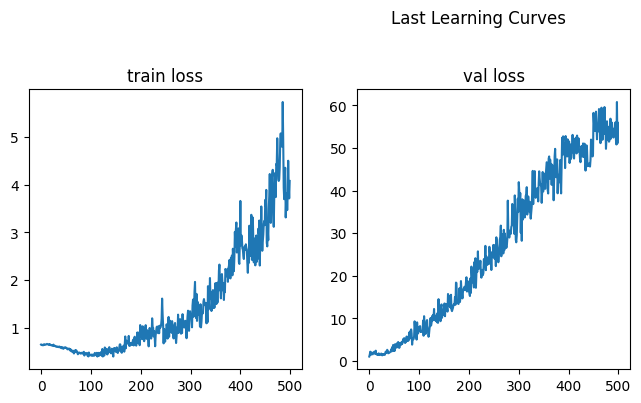

In [22]:
para_len = 72
epi_len = 48
kfold = 10

# how to choose epitope: 0 - random AA sequence as epitope; 1 - k-nearest AA as epitope
seq_clip_mode = 1 #0
# how to generate negative sample: 0 - random sample with dissimilarity rate 90% 1 - random sequence;
neg_sample_mode = 0 #1

data_type = "seq" + str(seq_clip_mode) + "_" + "neg" + str(neg_sample_mode)

batch_size = 8 #16 #128 #16
clip_norm = 1 # gradient clipping

# use_L2 = True
use_L2 = False

use_cache = True

# use_pair = True
use_pair = False

num_neg = 4

# folds_path = None
if use_pair==False:
    folds_path = "./data/processed_data_clip1_neg0.pkl"
elif use_pair==True:
    folds_path = "./data/processed_data_clip1_neg0_usepairTrue.pkl"
else:
    folds_path = None

# model name
# model_name = "demo"
# model_name = "lstm"
# model_name = "mlp"
# model_name = "InteractTransformer"
# model_name = "InteractTransformerLSTM"
# model_name = "SetTransformer"
# model_name = "SetCoAttnTransformer"
# model_name = "SetModel"
# model_name = "SetModel_ablation"
# model_name = "EnsembleModel"
# model_name = "PESI"

# model_list = ["masonscnn", 
#               "lstm", 
#               "InteractTransformer", 
#               "SetTransformer"]

# for model_name in model_list[2:]:
for model_name in ["SetCoAttnTransformer"]:
    
    if use_pair==True:
        model_name += "_encoder"

    print("training {} on SAbDab-full".format(model_name))
    
    os.makedirs("./results/SAbDab/full/{}/{}/".format(data_type, model_name), exist_ok=True)


    train_dataset = SAbDabDataset(data=data, epi_seq_length=epi_len, \
                                  seq_clip_mode=seq_clip_mode, neg_sample_mode=neg_sample_mode, \
                                  is_train_test_full="full", is_shuffle=True, \
                                  folds_path=folds_path, save_path=None, K=48, data_augment=False, \
                                  use_cache=use_cache, use_pair=use_pair, num_neg=num_neg)
    test_dataset = SeqDataset(data_path="../SARS-SAbDab_Shaun/CoV-AbDab_extract.csv", \
                              is_train_test_full="full", use_pair=use_pair)

    func = pair_collate_fn if use_pair else collate_fn
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=func)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, \
                                               collate_fn=func)

    if model_name=="masonscnn":
        model = MasonsCNN(amino_ft_dim=len(vocab), 
                          max_antibody_len=100, 
                          max_virus_len=100, 
                          h_dim=512, 
                          dropout=0.1).cuda()
        epochs = 300
        lr = 1e-4
        
    elif model_name=="masonscnn_encoder":
        model = CNNEncoder().cuda()
        
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="lstm":
        model = BiLSTM(embed_size=32, 
                       hidden=64, 
                       num_layers=1, 
                       dropout=0.5, 
                       use_pretrain=False).cuda()

        epochs = 300
        lr = 1e-4
        
    elif model_name=="lstm_encoder":
        model = BiLSTMEncoder(embed_size=64, hidden=64, num_layers=1).cuda()
        
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="InteractTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.3).cuda()
        epochs = 500
        lr = 6e-5
        
    elif model_name=="InteractTransformer_encoder":
        model = IntTransEncoder(embed_size=32, num_encoder_layers=1, nhead=2, dropout=0.5).cuda()
        
        epochs = 1000
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="InteractCoAttnTransformer":
        model = InteractTransformer(embed_size=32, 
                                    num_encoder_layers=1, 
                                    nhead=2, 
                                    dropout=0.5, 
                                    use_coattn=True).cuda()
        epochs = 500
        lr = 6e-5

    elif model_name=="InteractTransformerLSTM":
        model = InteractTransformerLSTM(embed_size=32, 
                                        hidden=64, 
                                        num_encoder_layers=1, 
                                        num_lstm_layers=1, 
                                        nhead=2, 
                                        dropout=0.5, 
                                        use_coattn=False).cuda()
        epochs = 500
        lr = 6e-5

    elif model_name=="SetTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=128, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=False, 
                               share=False).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="SetTransformer_encoder":
        model = SetEncoder(embed_size=32, 
                           num_outputs=32, 
                           dim_output=32, 
                           hidden=128, 
                           num_inds=6, 
                           num_heads=4, 
                           ln=True, 
                           dropout=0.5).cuda()
        epochs = 1000
        lr = 6e-5
        l2_coef = 5e-4
        
    elif model_name=="SetCoAttnTransformer":
        model = SetTransformer(dim_input=32, 
                               num_outputs=32, 
                               dim_output=32, 
                               dim_hidden=128, 
                               num_inds=6, 
                               num_heads=4, 
                               ln=True, 
                               dropout=0.5, 
                               use_coattn=True, 
                               share=False).cuda()
        epochs = 500
        lr = 6e-5
        l2_coef = 5e-4

    elif model_name=="SetModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=False, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 500
        lr = 3e-5
        
    elif model_name=="SetCoAttnModel":
        model = SetModel(embed_size=32, 
                         hidden=64, 
                         num_layers=1, 
                         dropout=0.3, 
                         k4kmer=3, 
                         use_pretrain=False, 
                         use_coattn=True, 
                         seq_encoder_type="transformer", 
                         num_heads=2, 
                         num_inds=6, 
                         num_outputs=6, 
                         ln=True).cuda()
        epochs = 500
        lr = 3e-5
        
    elif model_name=="EnsembleModel":
        model = EnsembleModel(embed_size=16, 
                      hidden=64, 
                      max_len=100, 
                      num_encoder_layers=1, 
                      num_heads=2, 
                      num_inds=6, 
                      num_outputs=6, 
                      ln=False, 
                      dropout=0.5, 
                      use_coattn=False).cuda()
        
        epochs = 500
        lr = 6e-5
        
#     elif model_name=="EnsembleModel1":
#         model = EnsembleModel(embed_size=16, 
#                       hidden=64, 
#                       max_len=100, 
#                       num_encoder_layers=1, 
#                       num_heads=2, 
#                       num_inds=6, 
#                       num_outputs=6, 
#                       ln=True, 
#                       dropout=0.5, 
#                       use_coattn=True).cuda()
        
#         epochs = 500
#         lr = 3e-5

    elif model_name=="PESI":
        model = PESI(embed_size=8, 
                     hidden=64, 
                     max_len=100, 
                     num_heads=2, 
                     num_inds=6, 
                     num_outputs=6, 
                     ln=True, 
                     dropout=0.5, 
                     use_coattn=True).cuda()
        
        epochs = 200
        lr = 5e-5
        l2_coef = 5e-4

    else:
        pass

    
    if use_L2==True:
        model_name += "_L2"

    print("model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

    criterion = nn.BCELoss() if use_pair==False else None
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6, last_epoch=-1)

    loss_buf = []
    val_loss_buf = []
    val_acc_buf = []
    val_f1_buf = []
    val_auc_buf = []
    best_train_loss = float("inf")
    best_val_loss = float("inf")

    for epoch in range(epochs):

        print("Epoch {}".format(epoch))

        loss_tmp = []
        if use_pair==False:
            for i, (para, epi, label) in enumerate(tqdm(train_loader)):
                optimizer.zero_grad()

                if use_pair==False:
                    pred = model(para, epi)
                    loss = criterion(pred.view(-1), label.view(-1).cuda())

                if use_L2 == True:
                    param_l2_loss = 0
                    for name, param in model.named_parameters():
                        if 'bias' not in name:
                            param_l2_loss += torch.norm(param, p=2)
                    param_l2_loss = l2_coef * param_l2_loss
                    loss += param_l2_loss

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

                optimizer.step()

                loss_tmp.append(loss.item())
                
            loss_buf.append(np.mean(loss_tmp))
                
        elif use_pair==True:
            for i, (para, epi_pos, epi_neg) in enumerate(tqdm(train_loader)):
                optimizer.zero_grad()

                y_pred_anc = model(para)
                y_pred_pos = model(epi_pos)
                y_pred_neg = model(epi_neg)
                
                if len(y_pred_anc.shape)==3:
                    y_pred_anc = torch.nn.functional.normalize(torch.mean(y_pred_anc, dim=1), p=2, dim=1)
                    y_pred_pos = torch.nn.functional.normalize(torch.mean(y_pred_pos, dim=1), p=2, dim=1)
                    y_pred_neg = torch.nn.functional.normalize(torch.mean(y_pred_neg, dim=1), p=2, dim=1)
                
                elif len(y_pred_anc.shape)==2:
                    y_pred_anc = torch.nn.functional.normalize(y_pred_anc, p=2, dim=1)
                    y_pred_pos = torch.nn.functional.normalize(y_pred_pos, p=2, dim=1)
                    y_pred_neg = torch.nn.functional.normalize(y_pred_neg, p=2, dim=1)
                
                loss = - (torch.dist(y_pred_anc, y_pred_pos, 2) - torch.dist(y_pred_anc, y_pred_neg, 2)).sigmoid().log().sum()

                if use_L2 == True:
                    param_l2_loss = 0
                    for name, param in model.named_parameters():
                        if 'bias' not in name:
                            param_l2_loss += torch.norm(param, p=2)
                    param_l2_loss = l2_coef * param_l2_loss
                    loss += param_l2_loss

                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)

                optimizer.step()

                loss_tmp.append(loss.item())

            loss_buf.append(np.mean(loss_tmp))
        else:
            print("wrong")
            exit()
            
    #     scheduler.step()
        print("lr: ", optimizer.param_groups[0]['lr'])
#         print("train loss {:.4f}\n".format(np.mean(loss_buf)))


        # evaluate
        if use_pair==False:
        
            with torch.no_grad():

                model.eval()

                preds = []
                labels = []
                val_loss_tmp = []
                for i, (para, epi, label) in enumerate(tqdm(test_loader)):

                    pred = model(para, epi)
                    val_loss = criterion(pred.view(-1), label.view(-1).cuda())

                    preds.append(pred.detach().cpu().view(-1))
                    labels.append(label.view(-1))
                    val_loss_tmp.append(val_loss.item())

                preds = torch.hstack(preds).view(-1)
                labels = torch.hstack(labels).view(-1)

                acc = accuracy_score(y_true=labels, y_pred=torch.round(preds))
                f1 = f1_score(y_true=labels, y_pred=torch.round(preds))
                auc = roc_auc_score(y_true=labels, y_score=preds)

                val_acc_buf.append(acc)
                val_f1_buf.append(f1)
                val_auc_buf.append(auc)
                val_loss_buf.append(np.mean(val_loss_tmp))

                print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f} \n Val Acc\t{:.4f} \n Val F1\t\t{:.4f} \n Val AUC\t{:.4f}".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf), acc, f1, auc))

                if np.mean(val_loss_tmp)<best_val_loss:
                    best_val_loss = np.mean(val_loss_tmp)
                    torch.save(model, "./results/SAbDab/full/{}/{}/model_best.pth".format(data_type, model_name))
                    np.save("./results/SAbDab/full/{}/{}/val_acc_best.npy".format(data_type, model_name), acc)
                    np.save("./results/SAbDab/full/{}/{}/val_f1_best.npy".format(data_type, model_name), f1)
                    np.save("./results/SAbDab/full/{}/{}/val_auc_best.npy".format(data_type, model_name), auc)

        elif use_pair==True:
#             if np.mean(loss_tmp)<best_train_loss:
#                 best_train_loss = np.mean(loss_tmp)
#                 torch.save(model, "./results/SAbDab/full/{}/{}/model_best.pth".format(data_type, model_name))
            with torch.no_grad():

                model.eval()

                preds = []
                labels = []
                val_loss_tmp = []
                for i, (para1, epi_pos1, epi_neg1) in enumerate(tqdm(test_loader)):

                    y_pred_anc1 = model(para1)
                    y_pred_pos1 = model(epi_pos1)
                    y_pred_neg1 = model(epi_neg1)
                    
                    if len(y_pred_anc1.shape)==3:
                        y_pred_anc1 = torch.nn.functional.normalize(torch.mean(y_pred_anc1, dim=1), p=2, dim=1)
                        y_pred_pos1 = torch.nn.functional.normalize(torch.mean(y_pred_pos1, dim=1), p=2, dim=1)
                        y_pred_neg1 = torch.nn.functional.normalize(torch.mean(y_pred_neg1, dim=1), p=2, dim=1)

                    elif len(y_pred_anc1.shape)==2:
                        y_pred_anc1 = torch.nn.functional.normalize(y_pred_anc1, p=2, dim=1)
                        y_pred_pos1 = torch.nn.functional.normalize(y_pred_pos1, p=2, dim=1)
                        y_pred_neg1 = torch.nn.functional.normalize(y_pred_neg1, p=2, dim=1)

                    val_loss = - (torch.dist(y_pred_anc1, y_pred_pos1, 2) - torch.dist(y_pred_anc1, y_pred_neg1, 2)).sigmoid().log().sum()

                    if use_L2 == True:
                        param_l2_loss1 = 0
                        for name, param in model.named_parameters():
                            if 'bias' not in name:
                                param_l2_loss1 += torch.norm(param, p=2)
                        param_l2_loss1 = l2_coef * param_l2_loss1
                        val_loss += param_l2_loss1

                    val_loss_tmp.append(val_loss.item())

                val_loss_buf.append(np.mean(val_loss_tmp))
                print("Epoch {}: \n Train Loss\t{:.4f} \n Val Loss\t{:.4f}\n".format(epoch, np.mean(loss_buf), np.mean(val_loss_buf)))

                if np.mean(val_loss_tmp)<best_val_loss:
                    best_val_loss = np.mean(val_loss_tmp)
                    torch.save(model, "./results/SAbDab/full/{}/{}/model_best.pth".format(data_type, model_name))
        else:
            print("Wrong")
            exit()


        torch.cuda.empty_cache()

        model.train()



    torch.save(model, "./results/SAbDab/full/{}/{}/model.pth".format(data_type, model_name))
    np.save("./results/SAbDab/full/{}/{}/loss_buf.npy".format(data_type, model_name), np.array(loss_buf))
    np.save("./results/SAbDab/full/{}/{}/val_loss_buf.npy".format(data_type, model_name), np.array(val_loss_buf))
    if use_pair==False:
        
        np.save("./results/SAbDab/full/{}/{}/val_acc_buf.npy".format(data_type, model_name), np.array(val_acc_buf))
        np.save("./results/SAbDab/full/{}/{}/val_f1_buf.npy".format(data_type, model_name), np.array(val_f1_buf))
        np.save("./results/SAbDab/full/{}/{}/val_auc_buf.npy".format(data_type, model_name), np.array(val_auc_buf))


    #     break
    
    evaluate(model_name, use_pair=True)

In [23]:
model_name

'SetCoAttnTransformer'

==================SetCoAttnTransformer================


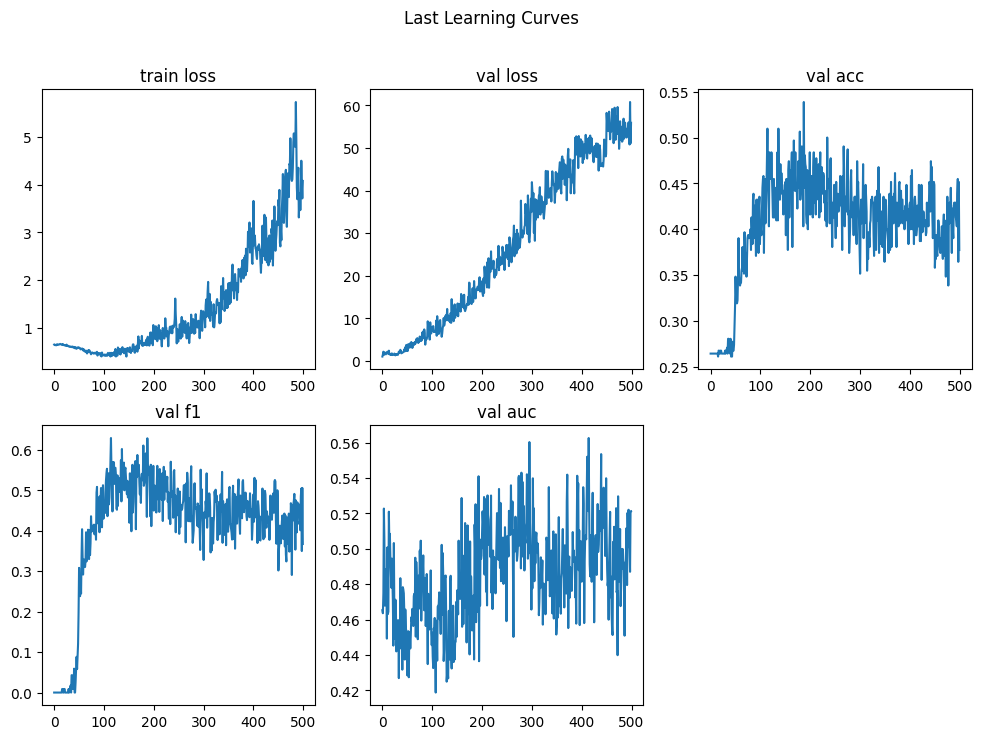

val acc mean:  0.2645161290322581
val f1 mean:  0.0
val auc mean:  0.4653401797175866


In [24]:
# not pair-wise
# no L2
evaluate("SetCoAttnTransformer")

==================masonscnn_encoder================


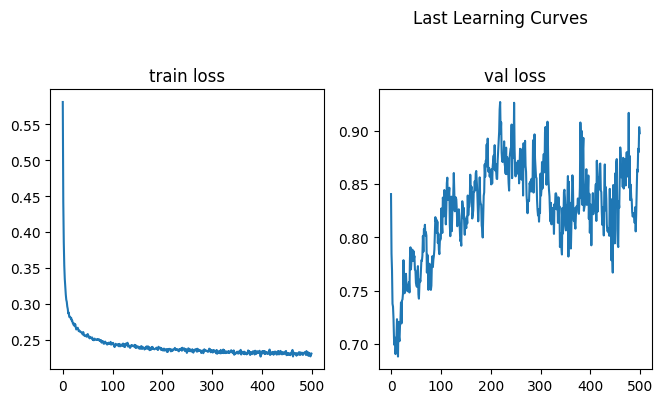

In [22]:
evaluate("masonscnn_encoder", use_pair=True)

==================lstm_encoder================


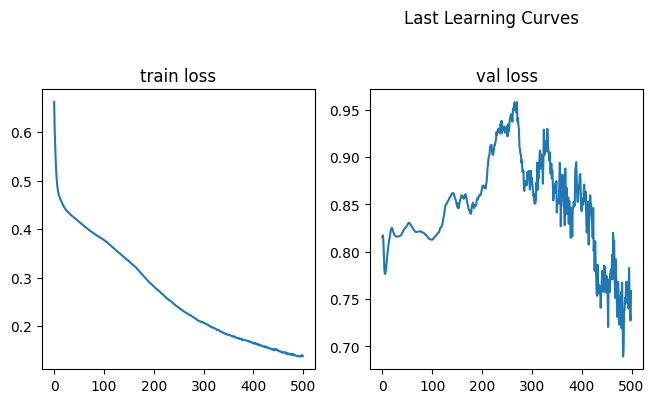

In [23]:
evaluate("lstm_encoder", use_pair=True)

In [ ]:
evaluate("InteractTransformer_encoder", use_pair=True)

In [ ]:
evaluate("SetTransformer_encoder", use_pair=True)